In [1]:
""" 
NOTEBOOK :  ntbk_figures_clim_data.ipynb 

This notebook produces the figures for the paper: 

 Boosting ensemble size of climate fields using generative machine learning; a proof of concept
  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX

STATUS  : Complete - needs checking results in full detail
COMMENTS: (1) The boosted ensemble appears to capture the known assymetries in 
              anomalies for el nino vs la nina, seen in the population and training sample
          (2) The variance of population extremes seems off   
"""""

' \nNOTEBOOK :  ntbk_figures_clim_data.ipynb \n\nThis notebook produces the figures for the paper: \n\n Boosting ensemble size of climate fields using generative machine learning; a proof of concept\n  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX\n\nSTATUS  : Complete - needs checking results in full detail\nCOMMENTS: (1) The boosted ensemble appears to capture the known assymetries in \n              anomalies for el nino vs la nina, seen in the population and training sample\n          (2) The variance of population extremes seems off   \n'

In [2]:
import os
import yaml 
import gc
import matplotlib.pyplot as plt


filename = f'{os.getcwd()[:-10]}/config.yaml'
with open(filename) as f:
    dict_yaml = yaml.load(f, Loader=yaml.loader.SafeLoader)

var            = dict_yaml['variable'][0]
dir_source     = dict_yaml['dir_source']
dir_frnt_out   = dict_yaml['dir_frnt_out']
dict_hist   = dict_yaml['data_hist_info']
list_data  = dict_yaml['list_data_raw'] + dict_yaml['list_data_hist']
dict_seasons = dict_yaml['dict_seasons']

In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, f'{dir_source}')

from modules.data_load     import load_hist_data
from modules.info_plt      import plt_module
from modules.plot_package  import plot_ts, plot_hist, plot_qq, plot_map
from modules.util_analysis import enso_extremes, corr_patt
from modules.util_glbavg   import *
from pathlib import Path


## Set Up ##

In [4]:
dir_out  = f'{dir_frnt_out}' 

In [5]:
dict_event_plt = plt_module().dict_event_plt
dict_hist_plt   = plt_module().dict_hist_plt

In [6]:
quantiles = np.linspace(start=0,stop=1,num=int(100))[1:-1]
quantiles_enso = ['None', '0.75', '0.85']
quantiles_extremes = [0.01, 0.99]
events    = ['nino', 'nina']

## Load Data ##

In [124]:
train_ensemble_size = eval(dict_yaml['data_hist_info']['hist_VAE1']['dir_in'].split('_TSE')[1].split('_')[0])

In [125]:
test_years = np.arange(1980,2020)

In [126]:
dict_data = load_hist_data([key for key in list_data if key != 'train_sample'],
                          dict_hist, train_ensemble_size=train_ensemble_size)

population
====
hist_VAE2
====
hist_VAE3
====
population_extention
====


In [127]:
equal_members = True

for key, ds in dict_data.items():
    dict_data[key] = ds.sel(year = test_years)
    if all([max(test_years) >= 2015, 'population' in key]):
        dict_data[key] = dict_data[key].sel(realization = [f'r{i}i1p2f1' for i in range(1,26)])
    if equal_members:
        try:
            dict_data[key] = dict_data[key].isel(realization = np.arange(len(dict_data['population'].realization)))
        except:
            pass

In [128]:
bias_correct = True

if bias_correct:
    for key, ds in dict_data.items():
        if all([key not in ['population', 'train_sample'], 'train_sample' in dict_data.keys()]):
            dict_data[key] = dict_data[key] - dict_data[key].mean(['realization','time']) + dict_data['train_sample'].mean(['realization','time'])

In [129]:
detrend = True


def linear_trend_polyfit(da, dim="year"):

    fit = da.polyfit(dim=dim, deg=1, skipna=True)
    coeffs = fit["polyfit_coefficients"]
    slope = coeffs.sel(degree=1)
    intercept = coeffs.sel(degree=0)

    return da[dim] * slope + intercept


if detrend:
    for key, ds in dict_data.items():
            print(key)
            # dict_data[key] = (dict_data[key] - linear_trend_polyfit(dict_data[key][var].mean('realization')).to_dataset(name = var) ).load()
            dict_data[key] = (dict_data[key] - (dict_data[key][var].mean('realization')).to_dataset(name = var) ).load()

population
hist_VAE2
hist_VAE3
train_sample


In [130]:
idisplay = True
if idisplay:
    for idata in list_data:
        display(dict_data[idata])

<xarray.Dataset>
Dimensions:      (time: 12, lat: 64, lon: 128, realization: 25, year: 40)
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * realization  (realization) object 'r1i1p2f1' 'r2i1p2f1' ... 'r25i1p2f1'
  * year         (year) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
Data variables:
    tas          (year, realization, time, lat, lon) float32 0.6292 ... -0.8959

<xarray.Dataset>
Dimensions:      (time: 12, lat: 64, lon: 128, realization: 1, year: 40)
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * realization  (realization) object 'r10i1p2f1'
  * year         (year) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
Data variables:
    tas          (year, realization, time, lat, lon) float32 0.0 0.0 ... 0.0 0.0

<xarray.Dataset>
Dimensions:      (lat: 64, lon: 128, time: 12, realization: 25, year: 40)
Coordinates:
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * realization  (realization) int64 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
  * year         (year) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
Data variables:
    tas          (year, time, realization, lat, lon) float32 -0.685 ... 3.281

<xarray.Dataset>
Dimensions:      (lat: 64, lon: 128, time: 12, realization: 25, year: 40)
Coordinates:
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * realization  (realization) int64 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
  * year         (year) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
Data variables:
    tas          (year, time, realization, lat, lon) float32 -0.4097 ... -0.6732

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


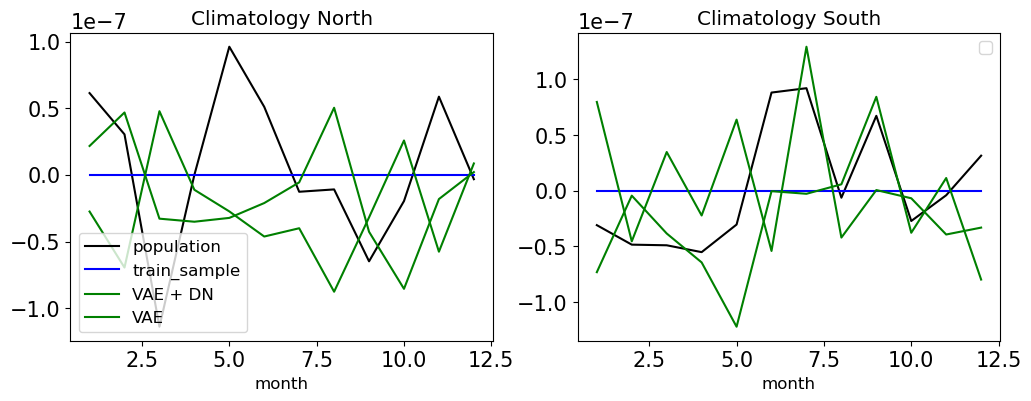

In [97]:
idisplay = True

if idisplay:

    plt.figure(figsize=(12,4))
    for i, hemisphere in enumerate(['North', 'South']):
        plt.subplot(1,2,i+1)
        for idata in list_data:
            if idata == 'obs':
                coords_for_clim = ['year', 'lat', 'lon']
            else:
                coords_for_clim = ['year','realization', 'lat', 'lon']
            if hemisphere == 'North':
                ds = dict_data[idata][var].where(dict_data[idata][var].lat >= 0 , drop = True).mean(coords_for_clim)
                plt.plot(np.arange(1,13), ds, color = dict_hist_plt[idata]['color'], label = dict_hist_plt[idata]['label'])
            else:
                ds = dict_data[idata][var].where(dict_data[idata][var].lat <= 0 , drop = True).mean(coords_for_clim)
                plt.plot(np.arange(1,13), ds, color = dict_hist_plt[idata]['color'])
        plt.title(f'Climatology {hemisphere}')
        plt.xlabel('month')
        plt.legend()

## Dictionaries ##

- Anomalies

In [131]:
dict_anom = {}
for idata in list_data:
    if idata == 'obs':
        coords_for_clim = ['year']
    else:
        coords_for_clim = ['year','realization']
    dict_anom[idata] = dict_data[idata] - dict_data[idata].mean(coords_for_clim)


    # if 'VAE' in idata:
    #     dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] <= dict_anom['train_sample'].max() )  ### through out outliers
    #     dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] >= dict_anom['train_sample'].min() ) ### through out outliers

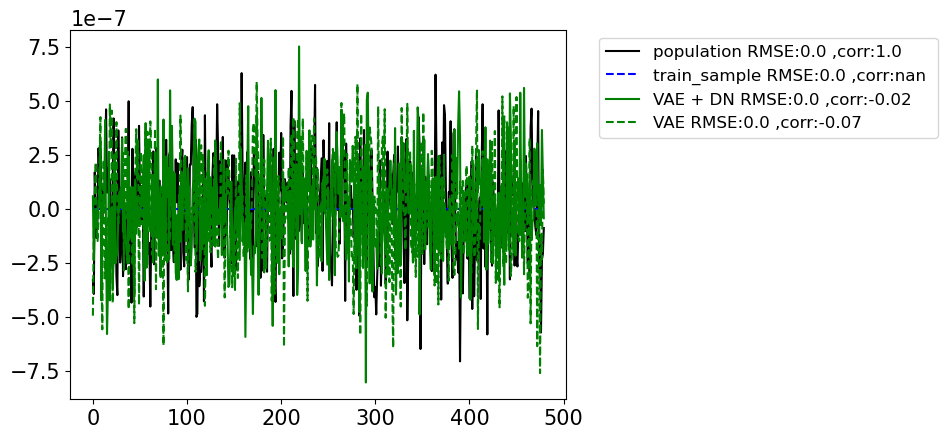

In [132]:
idisplay = True
ref = dict_anom['population'][var].mean(['realization', 'lat', 'lon']).stack(t = ('year', 'time')).squeeze()
if idisplay:
    plt.figure()
    for idata in list_data:
            if idata == 'obs':
                coords_for_clim =  ['lat', 'lon']
            else:
                coords_for_clim = ['realization', 'lat', 'lon']
            dstp = dict_anom[idata][var].mean(coords_for_clim).stack(t = ('year', 'time')).squeeze()
            rmse = np.round(np.sqrt(((ref - dstp)**2).mean()).values, 4)
            corr = np.round(xr.corr(ref, dstp, dim = 't').values, 2)

            plt.plot(dstp, color = dict_hist_plt[idata]['color'], label = dict_hist_plt[idata]['label'] + f' RMSE:{str(rmse)} ,corr:{str(corr)} ', linestyle = dict_hist_plt[idata]['linestyle'])
    
    # plt.legend(bbox_to_anchor = [1.05,1])
    # plt.figure()
    # for idata in list_data:
    #         if idata == 'obs':
    #             coords_for_clim =  ['lat', 'lon']
    #         else:
    #             coords_for_clim = ['realization', 'lat', 'lon']
    #         dstp = dict_anom[idata][var].mean(coords_for_clim).stack(t = ('year', 'time')).squeeze()
    #         corr = np.round(xr.corr(detrend_xr(ref, dim = 't'), detrend_xr(dstp, dim = 't'), dim = 't').values, 2)

    #         plt.plot(detrend_xr(dstp, dim = 't'), color = dict_hist_plt[idata]['color'], label = dict_hist_plt[idata]['label'] + f' corr:{str(corr)} ', linestyle = dict_hist_plt[idata]['linestyle'])
    
    plt.legend(bbox_to_anchor = [1.05,1])

- Quantiles

In [24]:
time_to_show = np.arange(1,13) 
dict_quantiles_flat = {}
for idata in list_data:
    print(idata)
    ds1 = dict_anom[idata][var].sel(time=time_to_show).values.flatten()
    ds1 = ds1[~np.isnan(ds1)]
    ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
    dict_quantiles_flat[idata] = ds1_quantiles  # uses median .. 

population
train_sample
hist_VAE2
hist_VAE3


- Figure 3: QQ Plot

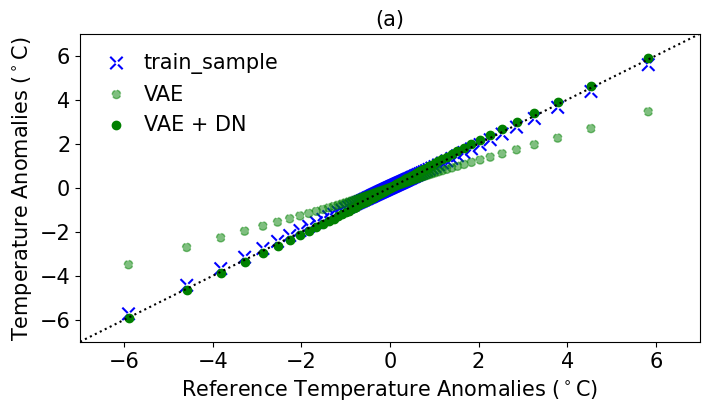

In [133]:
idata_ref = 'population'
plot_qq([key for key in ['train_sample','hist_VAE3','hist_VAE2'] if key != idata_ref],
        dict_quantiles_flat,
        idata_ref=idata_ref,
        dict_plt=dict_hist_plt,
        box=[[-7,-7],
             [7,7]],
            figsize=(8,4),
        bbox=(-0.15,.5,.5,.5),
        title = '(a)',
        # xlabel = '',
        dir_name= dir_frnt_out,
        file_name= 'Figure1_a',
        fontsize=15,
        show=True,
        save=False)

In [ ]:



plt.figure(figsize = (16,4))

ref = dict_anom['population'][var].std('realization').stack(t = ('year','time')).mean(['lat','lon']).squeeze()
for idata, ds in dict_anom.items():
    dstp =  ds[var].std('realization').stack(t = ('year','time')).mean(['lat','lon']).squeeze()
    corr = xr.corr(dstp, ref).values

    plt.plot( np.arange(min(test_years),max(test_years) + 1,1/12) , 
                dstp, 
                label = dict_hist_plt[idata]['label'] + f' {str(np.round(corr,2))}', 
                color  = dict_hist_plt[idata]['color'], 
                linestyle = dict_hist_plt[idata]['linestyle'])
plt.ylabel('Standard Deviation ($^\circ$C)')
plt.xlabel('time')
plt.legend()
plt.legend(loc='best',
            bbox_to_anchor=[1.005,1.005],
            handlelength=1,
            ncol=1,
            frameon=False)  


- global variability

0it [00:00, ?it/s]

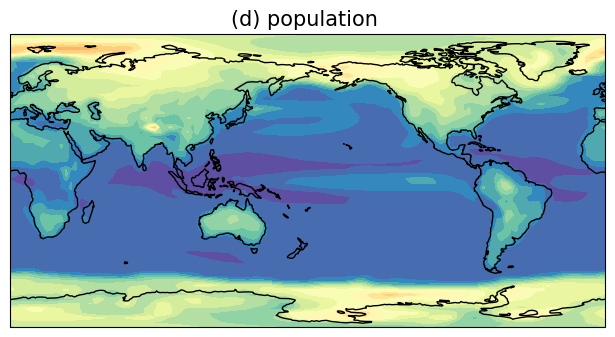

1it [00:01,  1.68s/it]

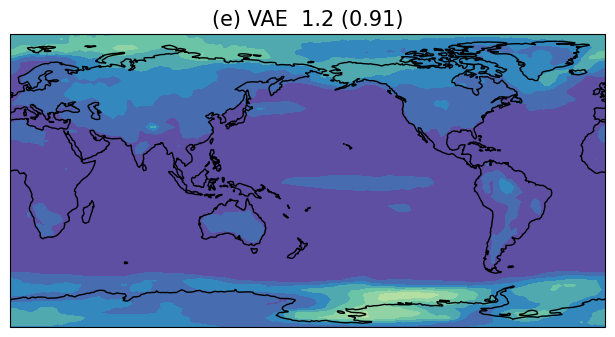

2it [00:03,  1.61s/it]

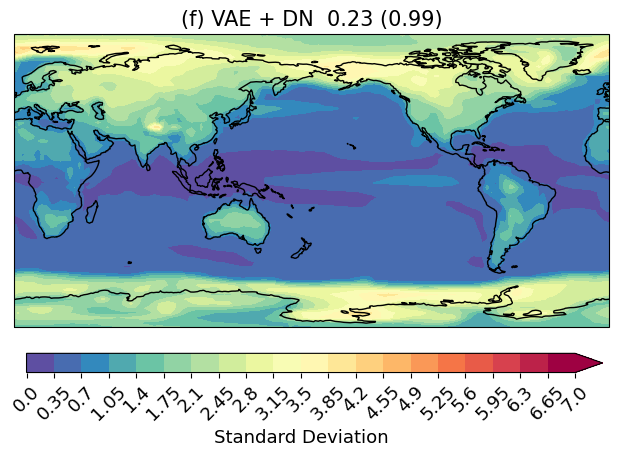

3it [00:05,  1.68s/it]


In [134]:
import string
from tqdm import tqdm
list_data_toplot = [ 'population', 'hist_VAE3', 'hist_VAE2']
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    ref_ds = dict_anom['population'][var].sel(time = dict_seasons[season]).stack(e = ('year','realization', 'time')).std(dim = 'e')#.mean('time')

    # plot_map((ref_ds),
    #                         title=f'{dict_hist_plt[ref]["label"]}, {season} ',
    #                         vmin=0,
    #                         vmax=7,
    #                         cbar=True,
    #                         cbar_label = 'TAS $^{o}C$',
    #                         fig_dir=f'{dir_out}', 
    #                             cmap='Spectral_r',
    #                             cbar_extend='max',

    #                         nvals = 20,
    #                         ticks_rotation = 45,
    #                         show=True,
    #                         dir_name= dir_frnt_out,
    #                         file_name= 'Figure1_c',
    #                         save=False)    
    
    for i, idata in tqdm(enumerate(list_data_toplot)):
                panel = string.ascii_lowercase[i + 3] 
                ds = dict_anom[idata][var].sel(time = dict_seasons[season]).stack(e = ('year','realization', 'time')).std(dim = 'e')#.mean('time')
                
                if idata != 'population':
                    corr = corr_patt(ref_ds, ds).mean().values
                    corr = f' ({str(np.round(corr,2))})'

                    rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
                    rmse = f' {str(np.round(rmse,2))}'
                else:
                       rmse = corr = ''

                
                cbar = True if i == len(list_data_toplot) - 1 else False
                plot_map((ds),
                            title=f'({panel}) {dict_hist_plt[idata]["label"]} ' + rmse + corr ,
                            vmin=0,
                            vmax=7,
                            cbar=cbar,
                            cbar_label = 'Standard Deviation',
                            fig_dir=f'{dir_out}',
                            cmap='Spectral_r',
                            cbar_extend='max',
                            nvals = 20,
                            fig_name= f'Figure1_{panel}',
                            fnt_size=15,
                            # figsize = (5,2),
                            ticks_rotation = 45,
                            show=True,
                            save=False)

- Nino 3.4

In [135]:
dict_enso = {}
for idata in list_data:
    dict_enso[idata] = dict_anom[idata].where((dict_anom[idata].lat >= -5) & (dict_anom[idata].lat<= 5),
                                              drop=True)
    dict_enso[idata] = dict_enso[idata].where((dict_enso[idata].lon >= 190) & (dict_enso[idata].lon<= 240),
                                              drop=True).mean(['lat','lon'])    

- Nino 3.4 seasoal cycle

In [136]:
dict_enso_seas_cycle = {}
for idata in list_data:
    dimension = ['realization','year']
    if idata in ['obs']:
        dimension = 'year'
    dict_enso_seas_cycle[idata] = dict_enso[idata].std(dimension)



- Nino 3.4 QQ plots

In [137]:
from tqdm import tqdm


In [138]:
mean_season = False

# seasons_to_show = ['DJF', 'JJA'] 
seasons_to_show = ['Full'] 
dict_quantiles_flat_enso = {}

for season in seasons_to_show:
    print(season)
    dict_quantiles_flat_enso[season] = {}
    for idata in tqdm(list_data):
        print(idata)
        ds1 = dict_enso[idata][var].sel(time=dict_seasons[season])
        if mean_season:
            ds1 = ds1.mean('time')
        ds1 = ds1.values.flatten()
        ds1 = ds1[~np.isnan(ds1)]
        ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
        dict_quantiles_flat_enso[season][idata] = ds1_quantiles  # uses median .. 

Full


100%|██████████| 4/4 [00:00<00:00, 944.03it/s]

population
train_sample
hist_VAE2
hist_VAE3


- Figure 3: Nino3.4 Seasonal Cycle

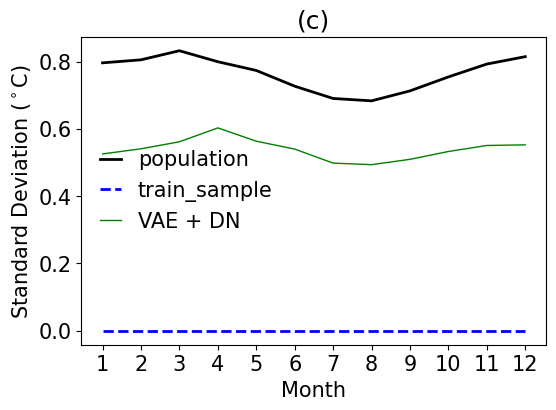

In [139]:
plot_ts(['population', 'train_sample',  'hist_VAE2'],
        dict_enso_seas_cycle,
        dict_plot=dict_hist_plt,
        bbox= None, #(-0,-0.1,.5,.5),
        figsize=(6,4),
        title=f'(c)',
        xlabel=f'Month',
        ylabel=f'Standard Deviation ($^\circ$C)',
        dir_name= dir_frnt_out,
        file_name= 'Figure4_c',
        show=True,
        save=False)

- ENSO Histograms

In [140]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full']
mean_season = False

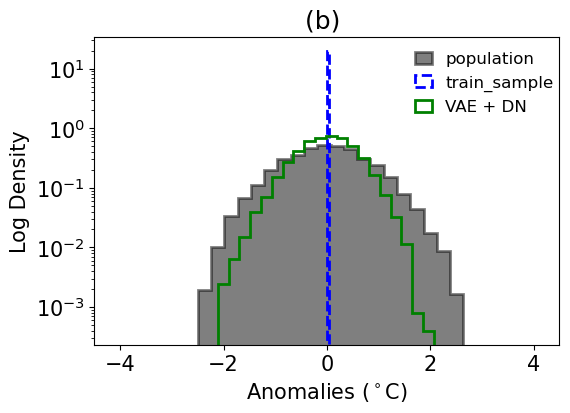

In [141]:
for season in seasons_to_show:
  plot_hist(['population', 'train_sample','hist_VAE2'],
            dict_enso,
            dict_hist_plt,
            season=season,
            seasons_dict = dict_seasons,
            mean_season=mean_season,
            figsize=(6,4),
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(b) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure4_b',
            legend_bool = (True, True, True),
            bbox=(0.52,.5,.5,.5),
            fontsize=15,
              xmin=-4.5,
              xmax=4.5,
              skewness=False,
            show = True,
            save = False)

- QQ plots

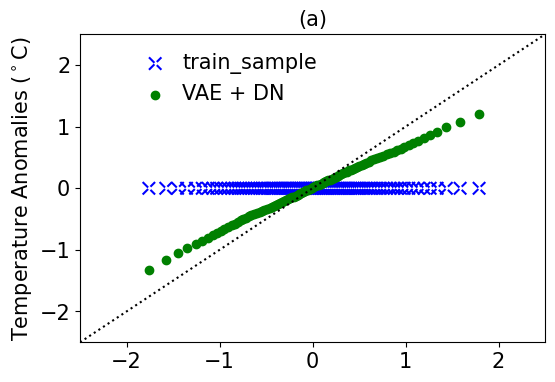

In [142]:
idata_ref = 'population'
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full']

for season in seasons_to_show:
    plot_qq([key for key in ['train_sample', 'hist_VAE2'] if key != idata_ref],
            dict_quantiles_flat_enso[season],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=[[-2.5,-2.5],
                [2.5,2.5]],
                figsize=(6,4),
            bbox=(0.05,.5,.5,.5),
            title = '(a)',
            xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure4_a',
            text_dict = {'text' : season, 'x' : 0.9, 'y' : 0.05, 'fontsize' :15} if season != 'Full' else None,
            show=True,
            save=False)

- time series

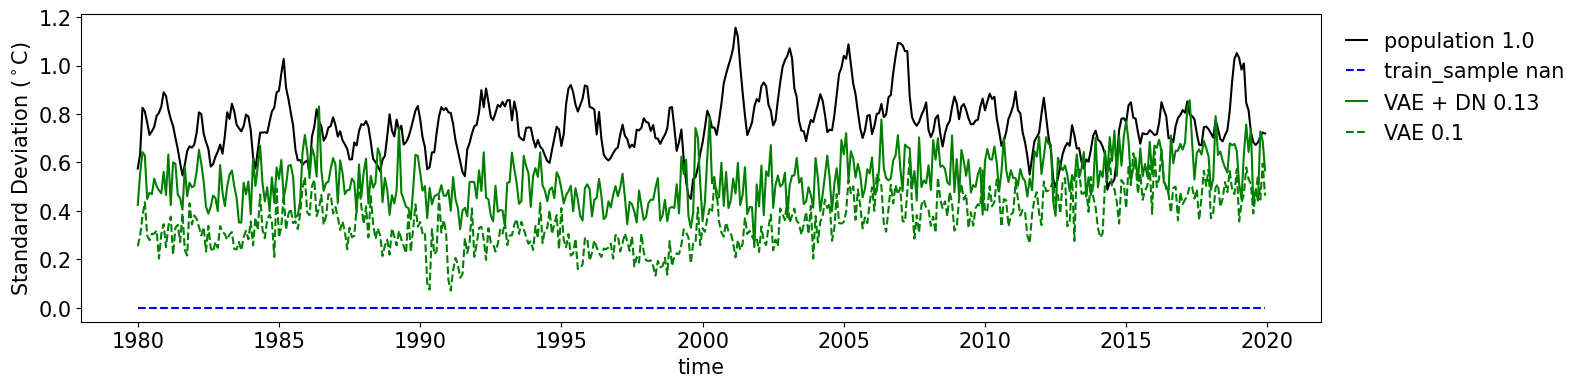

In [35]:



plt.figure(figsize = (16,4))

ref = dict_enso['population'][var].std('realization').stack(t = ('year','time')).squeeze()
for idata, ds in dict_enso.items():
    dstp =  ds[var].std('realization').stack(t = ('year','time')).squeeze()
    corr = xr.corr(dstp, ref).values

    plt.plot( np.arange(min(test_years),max(test_years) + 1,1/12) , 
                dstp, 
                label = dict_hist_plt[idata]['label'] + f' {str(np.round(corr,2))}', 
                color  = dict_hist_plt[idata]['color'], 
                linestyle = dict_hist_plt[idata]['linestyle'])
plt.ylabel('Standard Deviation ($^\circ$C)')
plt.xlabel('time')
plt.legend()
plt.legend(loc='best',
            bbox_to_anchor=[1.005,1.005],
            handlelength=1,
            ncol=1,
            frameon=False)  


- Figure 3: Regional Analysis - Vancouver London 

In [143]:
dict_regional_anom = {}

for region in ['Vancouver', 'London', 'Hong Kong','Los Angles']:
    dict_regional_anom[region] = {}

for idata in list_data:
    ds = dict_anom[idata].load()
    # d = dict_anom[idata].where((dict_anom[idata].lat >= 48) & (dict_anom[idata].lat<= 70),
    #                                           drop=True)
    # dict_regional_anom['Canada'][idata] = d.where((d.lon >= 219) & (d.lon<= 304),
    #                                           drop=True).mean(['lat','lon'])     
    dict_regional_anom['Vancouver'][idata] = ds.sel(lat = 46, lon = 237,  method='nearest')
    dict_regional_anom['London'][idata] = ds.sel(lat = 51.5, lon = 0,  method='nearest')
    dict_regional_anom['Hong Kong'][idata] = ds.sel(lat = 22.3, lon = 114,  method='nearest')
    dict_regional_anom['Los Angles'][idata] = ds.sel(lat = 34.1, lon = -118.2 + 360,  method='nearest')


In [144]:
for region in dict_regional_anom.keys():

    samples = np.random.normal(loc=dict_regional_anom[region]['population']['tas'].mean(), scale=dict_regional_anom[region]['population']['tas'].std(), size=dict_regional_anom[region]['population']['tas'].shape)

    dict_regional_anom[region]['hist_benchmark'] =  dict_regional_anom[region]['population']['tas'].copy()
    dict_regional_anom[region]['hist_benchmark'].data = samples
    dict_regional_anom[region]['hist_benchmark'] = dict_regional_anom[region]['hist_benchmark'].to_dataset()


In [145]:
dict_regional_anom_seas_cycle = {}

for key, ds in dict_regional_anom.items():
    dict_regional_anom_seas_cycle[key] = {}
    for idata in list_data:
        dimension = ['realization','year']
        if idata in ['obs']:
            dimension = 'year'
        dict_regional_anom_seas_cycle[key][idata] = dict_regional_anom[key][idata].std(dimension)

In [146]:
from tqdm import tqdm

In [147]:
mean_season = False
# seasons_to_show = ['DJF', 'JJA'] 
seasons_to_show = ['Full'] 
dict_quantiles_flat_regional = {}


for season in seasons_to_show:
    print(season)
    dict_quantiles_flat_regional[season] = {}
    for key, ds in dict_regional_anom.items():
        dict_quantiles_flat_regional[season][key] = {}
        for idata in tqdm(list_data):
                print(idata)
                ds1 = dict_regional_anom[key][idata][var].sel(time=dict_seasons[season])
                if mean_season:
                    ds1 = ds1.mean('time')
                ds1 = ds1.values.flatten()
                ds1 = ds1[~np.isnan(ds1)]
                ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
                dict_quantiles_flat_regional[season][key][idata] = ds1_quantiles  # uses median .. 



Full


100%|██████████| 4/4 [00:00<00:00, 856.20it/s]


population
train_sample
hist_VAE2
hist_VAE3


100%|██████████| 4/4 [00:00<00:00, 966.99it/s]


population
train_sample
hist_VAE2
hist_VAE3


100%|██████████| 4/4 [00:00<00:00, 1014.59it/s]


population
train_sample
hist_VAE2
hist_VAE3


100%|██████████| 4/4 [00:00<00:00, 990.57it/s]

population
train_sample
hist_VAE2
hist_VAE3


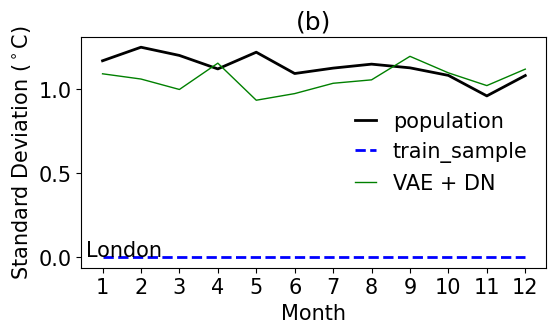

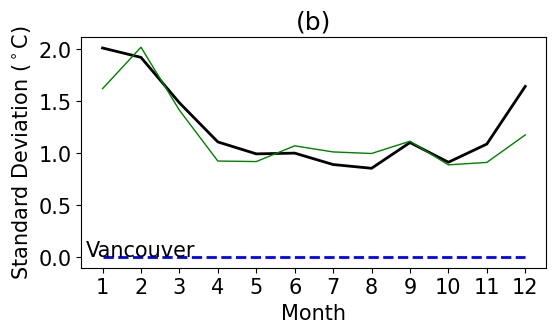

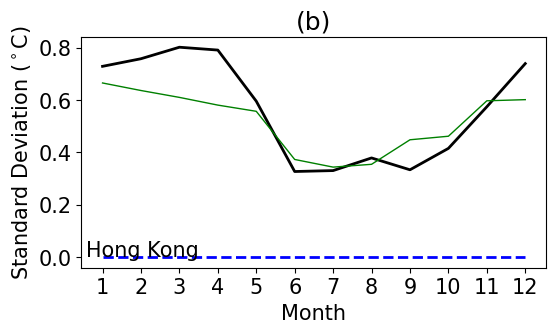

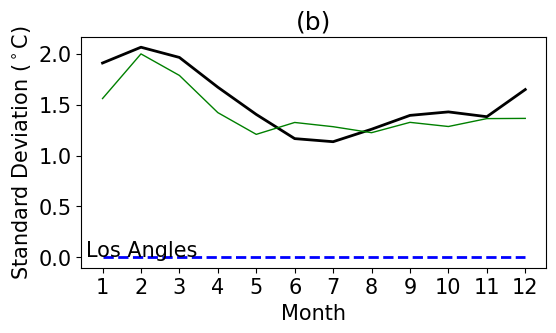

In [148]:

for ind, region in enumerate([ 'London','Vancouver', 'Hong Kong', 'Los Angles']):
        panel = panel = string.ascii_lowercase[ind] 
        legend = True if ind == 0 else False
        plot_ts(['population', 'train_sample', 'hist_VAE2'],
                dict_regional_anom_seas_cycle[region],
                dict_plot=dict_hist_plt,
                bbox= None, #(-0,-0.1,.5,.5),
                figsize=(6,3),
                title=f'(b)',
                xlabel=f'Month',
                ylabel=f'Standard Deviation ($^\circ$C)',
                text_dict = {'text' : region, 'x': 0.01, 'y':0.05, 'fontsize' :15 },
                dir_name= dir_frnt_out, 
                legend = legend,
                file_name= f'FigureS4_{panel}',
                show=True,
                save=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


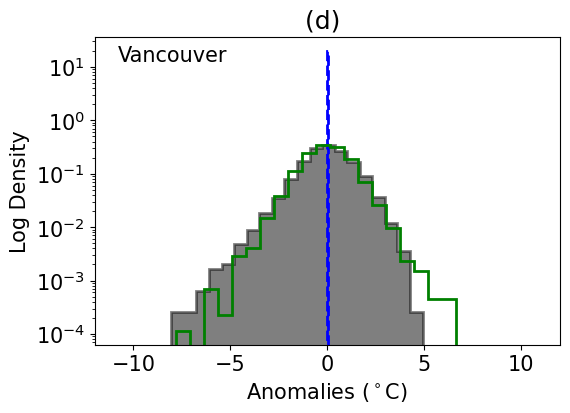

In [149]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Vancouver'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-8.5
        xmax=8.5
  else:
        xmin=-12
        xmax=12

  
  plot_hist(['population', 'train_sample', 'hist_VAE2'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
            figsize = (6,4),
            mean_season=mean_season,
            text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(d) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure2_d',
            legend_bool = (False, False, False),
            bbox=(0.52,.5,.5,.5),
            fontsize=15,
              xmin=xmin,
              xmax=xmax,
              skewness = False,
            show = True,
            save = False)

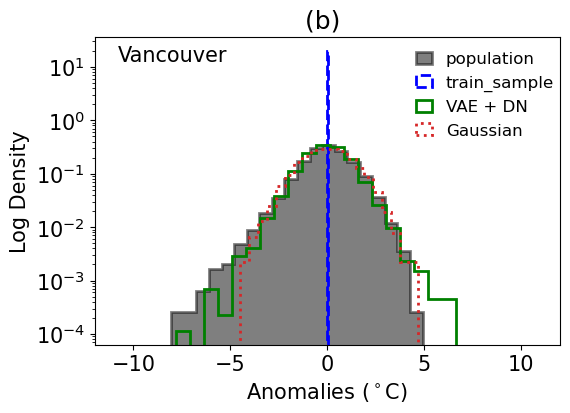

In [150]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Vancouver'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-8.5
        xmax=8.5
  else:
        xmin=-12
        xmax=12

  
  plot_hist(['population', 'train_sample', 'hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
            figsize = (6,4),
            mean_season=mean_season,
            text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(b) ',
                fig_dir= dir_frnt_out,
            fig_name= 'FigureS2_b',
            legend_bool = (True, True, True, True),
            bbox=(0.52,.5,.5,.5),
            fontsize=15,
              xmin=xmin,
              xmax=xmax,
              skewness = False,
            show = True,
            save = False)

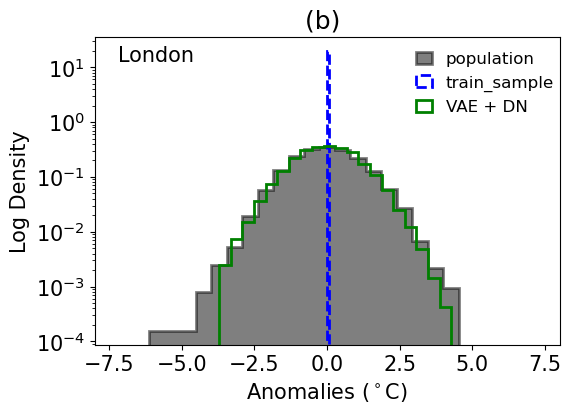

In [151]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'London'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-8.5
        xmax=8.5
  else:
        xmin=-8
        xmax=8     

  
  plot_hist(['population', 'train_sample', 'hist_VAE2'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
                        figsize = (6,4),
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(b) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure2_b',
            fontsize=15,
            legend_bool = (True, True, True),
            bbox=(0.52,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = False,
            show = True,
            save = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


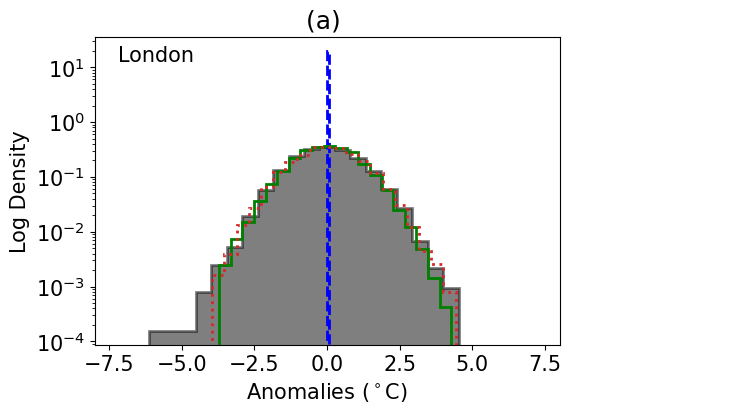

In [152]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'London'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-8.5
        xmax=8.5
  else:
        xmin=-8
        xmax=8     

  
  plot_hist(['population', 'train_sample', 'hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
                        figsize = (6,4),
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(a) ',
                fig_dir= dir_frnt_out,
            fig_name= 'FigureS2_a',
            fontsize=15,
            legend_bool = (False, False, False, False),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


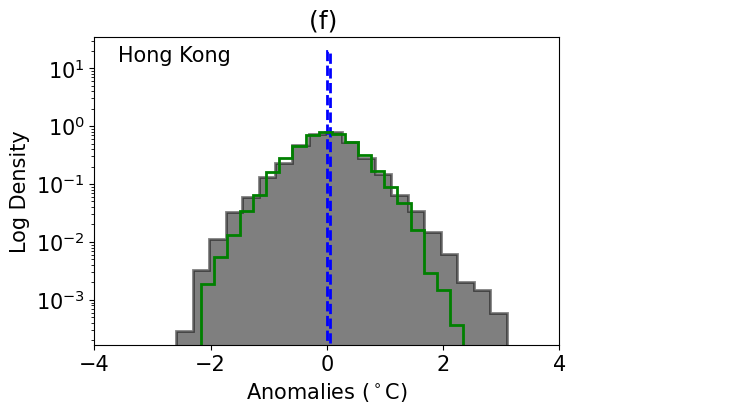

In [153]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Hong Kong'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-5
        xmax=5
  else:
        xmin=-4
        xmax=4     
  
  plot_hist(['population', 'train_sample', 'hist_VAE2'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
                        figsize = (6,4),
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(f) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure2_f',
            fontsize=15,
            legend_bool = (False, False, False),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


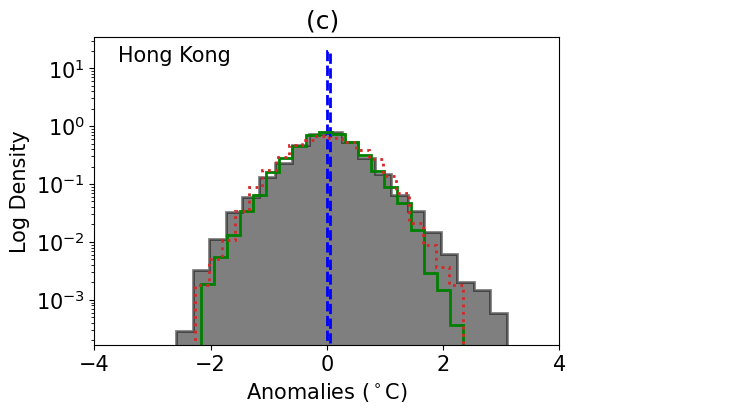

In [154]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Hong Kong'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-5
        xmax=5
  else:
        xmin=-4
        xmax=4     
  
  plot_hist(['population', 'train_sample', 'hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
                        figsize = (6,4),
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(c) ',
                fig_dir= dir_frnt_out,
            fig_name= 'FigureS2_c',
            fontsize=15,
            legend_bool = (False, False, False, False),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


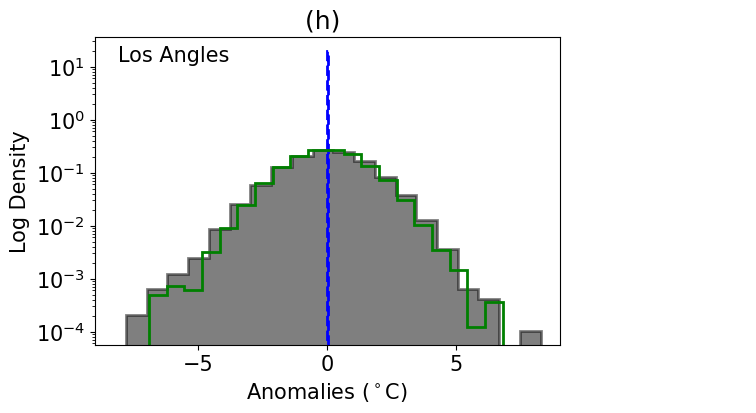

In [155]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Los Angles'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-5
        xmax=5
  else:
        xmin=-9
        xmax=9
  
  plot_hist(['population', 'train_sample', 'hist_VAE2'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
            
                        figsize = (6,4),
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(h) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure2_h',
            fontsize=15,
            legend_bool = (False, False, False),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


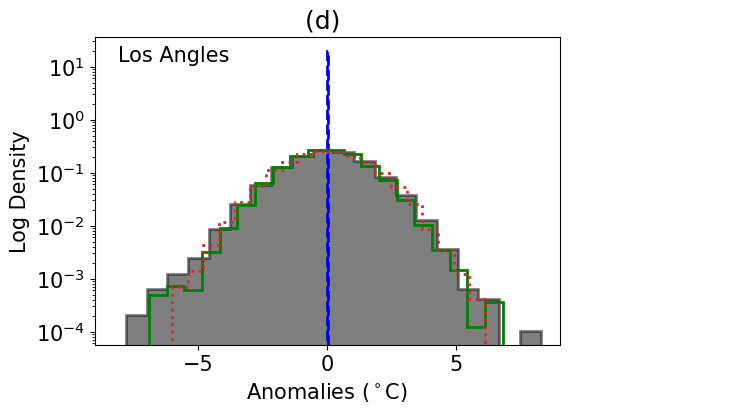

In [156]:
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Los Angles'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-5
        xmax=5
  else:
        xmin=-9
        xmax=9
  
  plot_hist(['population', 'train_sample', 'hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.92, 'fontsize' : 15},
            nbins=20,
            
                        figsize = (6,4),
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(d) ',
                fig_dir= dir_frnt_out,
            fig_name= 'FigureS2_d',
            fontsize=15,
            legend_bool = (False, False, False, False),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

In [37]:
# seasons_to_show = ['DJF', 'JJA']
# # seasons_to_show = ['Full'] 

# region = 'Canada'
# for season in seasons_to_show:
#   if season == 'DJF':
#         xmin=-8.5
#         xmax=8.5
#   else:
#         xmin=-5
#         xmax=5     

  
#   plot_hist(['population', 'train_sample','hist_VAE2', 'hist_benchmark'],
#             dict_regional_anom[region],
#             dict_hist_plt,
#             season=season,
#             mean_season=mean_season,
#              text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.95},
#             nbins=20,
#             xlabel='Anomalies ($^\circ$C)',
#             ylabel='Log Density',
#             title='(d) ',
#                 fig_dir= dir_frnt_out,
#             fig_name= 'Figure3_d',
#             legend_bool = (True, True, True, True),
#             bbox=(0.92,.5,.5,.5),
#               xmin=xmin,
#               xmax=xmax,
#               skewness = True,
#             show = True,
#             save = False)

- qq plots

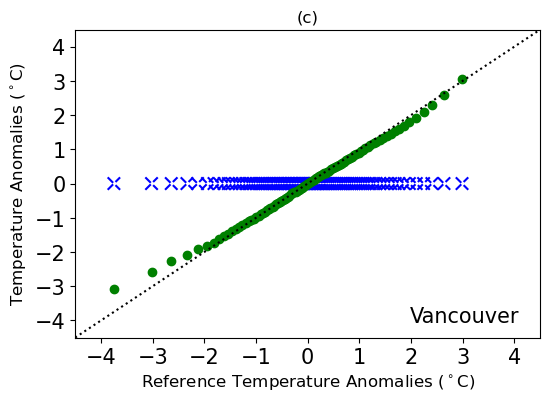

In [157]:
idata_ref = 'population'
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Vancouver'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-5.5,-5.5],
                [5.5,5.5]]
    else:
            box=[[-4.5,-4.5],
                [4.5,4.5]]
    plot_qq([key for key in ['train_sample', 'hist_VAE2'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,
                figsize=(6,4),
            bbox=(-0.1,.5,.5,.5),
            title = '(c)',
            # xlabel = '',
            add_error=False,
            legend=False,
            fontsize=12,
            dir_name= dir_frnt_out,
            file_name= 'Figure2_c',
             text_dict = {'text' : season + f' {region}',  'x' : 0.75, 'y' : 0.05, 'fontsize' : 15} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.72, 'y' : 0.05, 'fontsize' : 15},
            show=True,
            save=False)

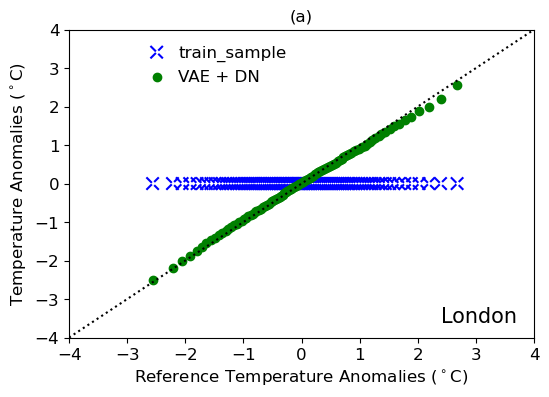

In [158]:
idata_ref = 'population'
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'London'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-5.5,-5.5],
                [5.5,5.5]]
    else:
            box=[[-4,-4],
                [4,4]]
    plot_qq([key for key in ['train_sample','hist_VAE2'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,
                figsize=(6,4),
            bbox=(0,.5,.5,.5),
            title = '(a)',
            add_error=False,
            fontsize=12,
            # xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure2_a',
             text_dict = {'text' : season + f' {region}',  'x' : 0.75, 'y' : 0.05, 'fontsize' : 15} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.8, 'y' : 0.05, 'fontsize' : 15},
            show=True,
            save=False)

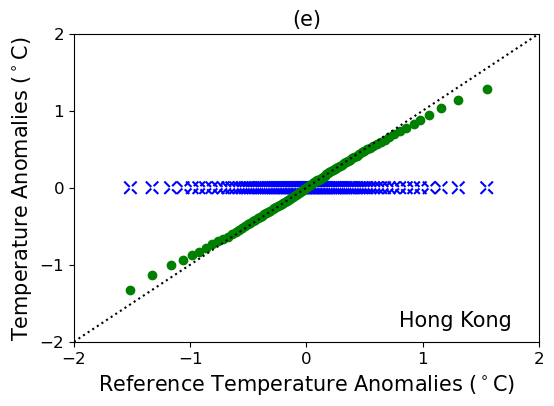

In [159]:
idata_ref = 'population'
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Hong Kong'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-3,-3],
                [3,3]]
    else:
            box=[[-2,-2],
                [2,2]]
    plot_qq([key for key in ['train_sample','hist_VAE2'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,
                figsize=(6,4),
            bbox=(0.2,.5,.5,.5),
            legend=False,
            title = '(e)',
            add_error=True,
            # xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure2_e',
             text_dict = {'text' : season + f' {region}',  'x' : 0.75, 'y' : 0.05, 'fontsize' : 15} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.7, 'y' : 0.05, 'fontsize' : 15},
            show=True,
            save=False)

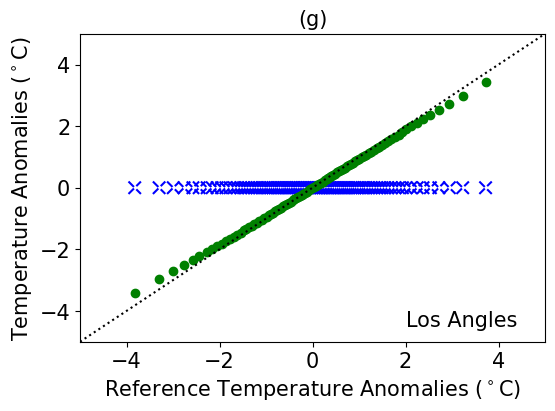

In [160]:
idata_ref = 'population'
# seasons_to_show = ['DJF', 'JJA']
seasons_to_show = ['Full'] 

region = 'Los Angles'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-3,-3],
                [3,3]]
    else:
            box=[[-5,-5],
                [5,5]]
    plot_qq([key for key in ['train_sample','hist_VAE2'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,
                figsize=(6,4),
            bbox=(0.2,.5,.5,.5),
            legend=False,
            title = '(g)',
            add_error=True,
            # xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure2_g',
             text_dict = {'text' : season + f' {region}',  'x' : 0.75, 'y' : 0.05, 'fontsize' : 15} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.7, 'y' : 0.05, 'fontsize' : 15},
            show=True,
            save=False)

- time series

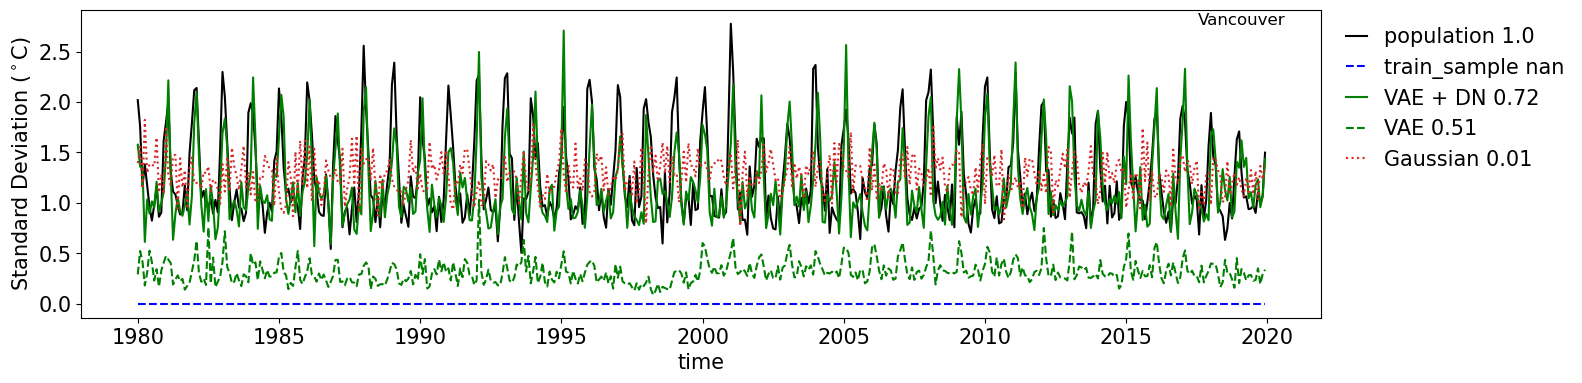

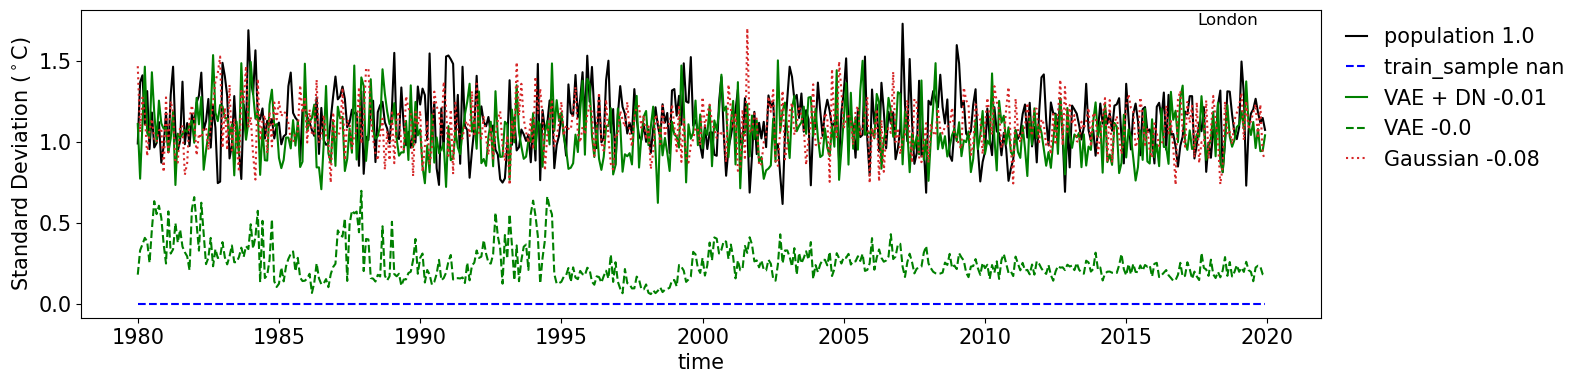

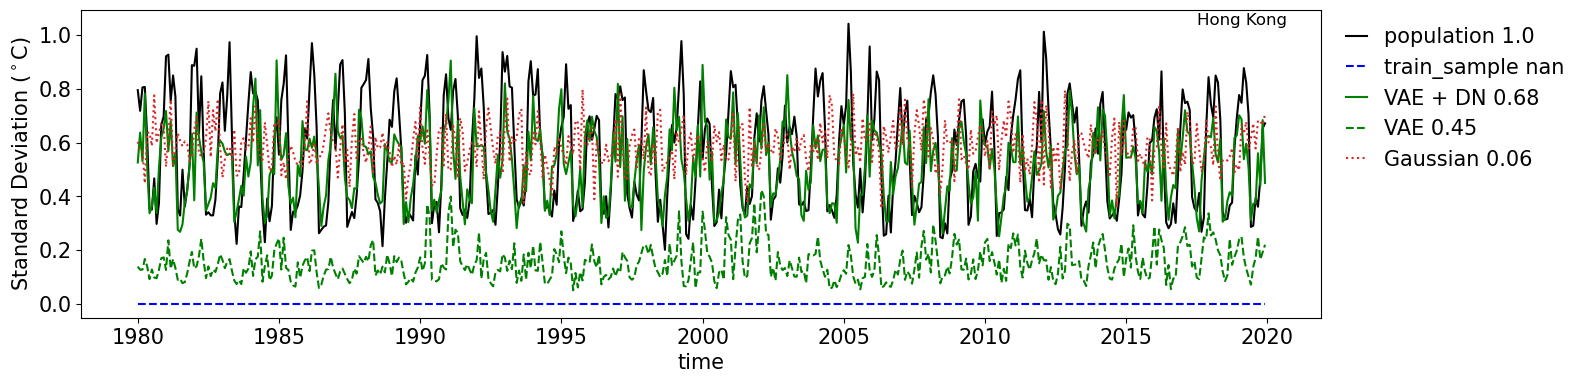

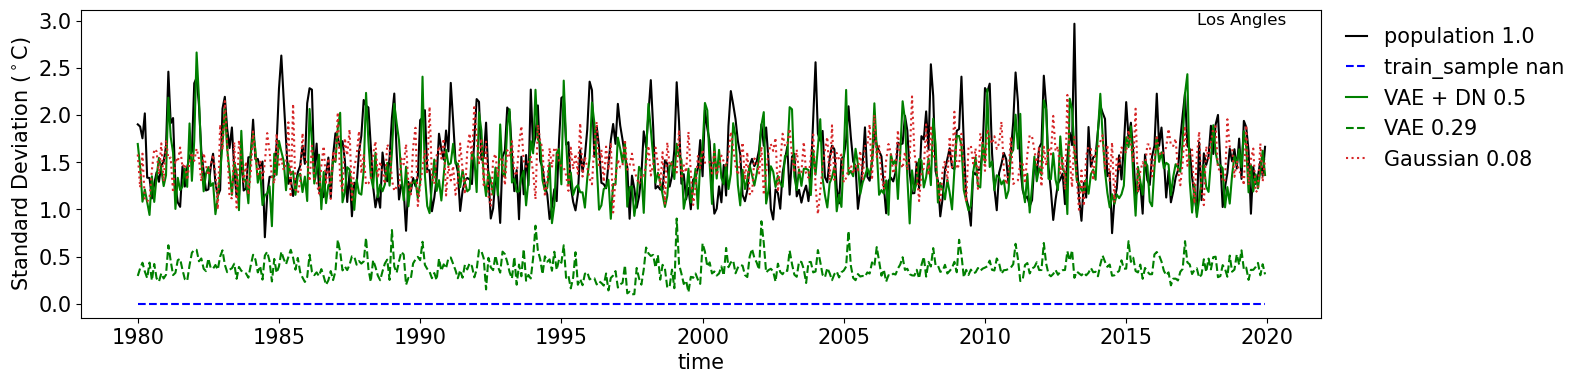

In [161]:


for region in dict_regional_anom.keys():
    plt.figure(figsize = (16,4))

    ref = dict_regional_anom[region]['population'][var].std('realization').stack(t = ('year','time')).squeeze()
    for idata, ds in dict_regional_anom[region].items():
        dstp =  ds[var].std('realization').stack(t = ('year','time')).squeeze()
        corr = xr.corr(dstp, ref).values

        plt.plot( np.arange(min(test_years),max(test_years) + 1,1/12) , 
                 dstp, 
                 label = dict_hist_plt[idata]['label'] + f' {str(np.round(corr,2))}', 
                 color  = dict_hist_plt[idata]['color'], 
                 linestyle = dict_hist_plt[idata]['linestyle'])
    plt.ylabel('Standard Deviation ($^\circ$C)')
    plt.xlabel('time')
    plt.legend()
    plt.legend(loc='best',
                bbox_to_anchor=[1.005,1.005],
                handlelength=1,
                ncol=1,
                frameon=False)  
    plt.text(0.9,0.95,region,    fontsize = 12,
        transform=plt.gca().transAxes) 

- skewness

In [162]:
def skewness(ds, axis = 0):
    n = ds.shape[axis]
    dim = ds.dims[axis]
    mean = ds.mean(dim)
    denom = ((ds - mean)**2).mean(dim)

    s = ((ds - mean)**3).mean(dim) / denom ** (1.5)
    return s * np.sqrt( n * (n-1)) / (n-2)

def kurtosis(ds, axis = 0):
    n = ds.shape[axis]
    dim = ds.dims[axis]
    mean = ds.mean(dim)
    denom = ((ds - mean)**2).mean(dim)

    k = ((ds - mean)**4).mean(dim) / denom ** (2)
    return ((n - 1)/(n-2)/(n-3)) * ( (n+1)*k - 3*(n-1) + 3)


0it [00:00, ?it/s]

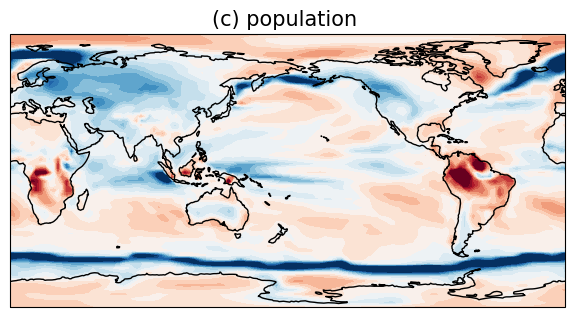

1it [00:04,  4.56s/it]

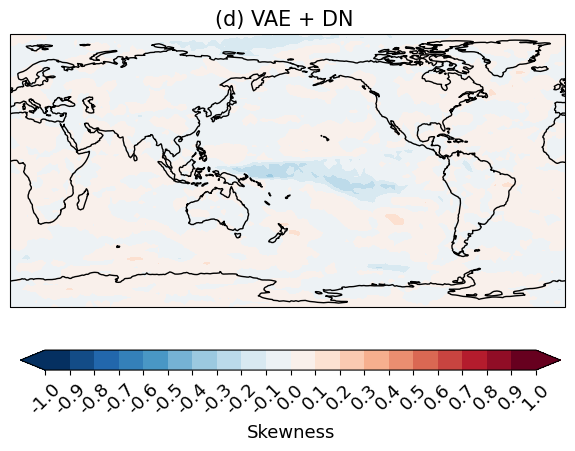

2it [00:08,  4.37s/it]


In [163]:
list_data_toplot = [ 'population', 'hist_VAE2']
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    sk = skewness(dict_anom['population'][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
    ref_ds = (xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon))


    
    for i, idata in tqdm(enumerate(list_data_toplot)):
                panel = string.ascii_lowercase[i + 2] 
                sk = skewness(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
                ds = (xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon))

                # corr = corr_patt(ref_ds, ds).mean().values
                # corr = f' ({str(np.round(corr,2))})'

                # rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
                # rmse = f' {str(np.round(rmse,2))}'
                
                cbar = True if i == len(list_data_toplot) - 1 else False
                plot_map((ds),
                            title=f'({panel}) {dict_hist_plt[idata]["label"]} ' ,
                            vmin=-1,
                            vmax=1,
                            cbar=cbar,
                            nvals = 20,
                            cbar_label = 'Skewness',
                            fig_dir=f'{dir_out}',
                            fig_name=f'Figure3_{panel}',
                            figsize = (6,5),
                            ticks_rotation = 45,
                            fnt_size = 15,
                            show=True,
                            save=False)

0it [00:00, ?it/s]

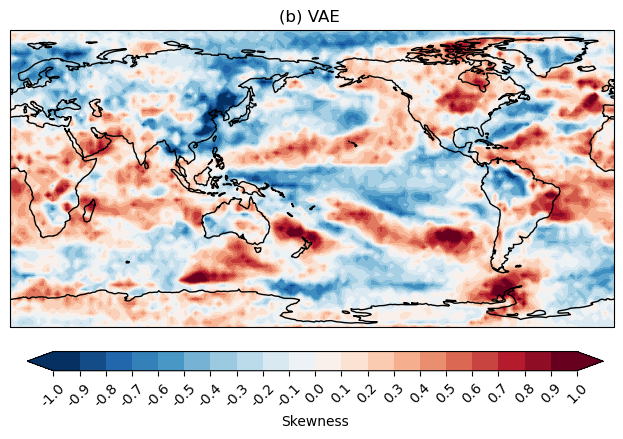

1it [00:05,  5.45s/it]


In [164]:
list_data_toplot = [ 'hist_VAE3']
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    sk = skewness(dict_anom['population'][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
    ref_ds = (xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon))


    
    for i, idata in tqdm(enumerate(list_data_toplot)):
                panel = string.ascii_lowercase[i + 1] 
                sk = skewness(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
                ds = (xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon))

                # corr = corr_patt(ref_ds, ds).mean().values
                # corr = f' ({str(np.round(corr,2))})'

                # rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
                # rmse = f' {str(np.round(rmse,2))}'
                
                cbar = True if i == len(list_data_toplot) - 1 else False
                plot_map((ds),
                            title=f'({panel}) {dict_hist_plt[idata]["label"]} ' ,
                            vmin=-1,
                            vmax=1,
                            cbar=cbar,
                            cbar_label = 'Skewness',
                            fig_dir=f'{dir_out}',
                            fig_name=f'FigureS2_{panel}',
                            ticks_rotation = 45,
                            nvals=20,
                            show=True,
                            save=False)

In [ ]:
# list_data_toplot = [ 'train_sample', 'hist_VAE1', 'hist_VAE2']
# ref = 'population'

# seaons_to_plot = ['Full']

# for season in seaons_to_plot:
#     sk = skewness(dict_anom['population'][var].sel(time = dict_seasons[season]).transpose(...,'realization'), axis = -1)
#     ref_ds = xr.DataArray(sk, dims = ('year','time', 'lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon, year = dict_anom['population'][var].year, time = dict_anom['population'][var].time)

#     plot_map(ref_ds.mean(['year', 'time']),
#                             title=f'{dict_hist_plt[ref]["label"]}, {season} ',
#                             vmin=-1,
#                             vmax=1,
#                             cbar=True,
#                             cbar_label = 'TAS $^{o}C$',
#                             fig_dir=f'{dir_out}', 
#                             # fig_name=f'Figure5_{panel}',
#                             show=True,
#                             save=False)    
    
#     for i, idata in tqdm(enumerate(list_data_toplot)):
                
#                 sk = skewness(dict_anom[idata][var].sel(time = dict_seasons[season]).transpose(...,'realization'), axis = -1)
#                 ds = xr.DataArray(sk, dims = ('year','time', 'lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon, year = dict_anom[idata][var].year, time = dict_anom[idata][var].time)

#                 corr = corr_patt(ref_ds, ds).mean().values
#                 corr = f' ({str(np.round(corr,2))})'

#                 rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
#                 rmse = f' {str(np.round(rmse,2))}'

                
#                 cbar = True if i == 0 else False
#                 plot_map((ds).mean(['year', 'time']),
#                             title=f'{dict_hist_plt[idata]["label"]}, {season} ' + rmse + corr ,
#                             vmin=-1,
#                             vmax=1,
#                             cbar=cbar,
#                             cbar_label = 'Skewness',
#                             fig_dir=f'{dir_out}',
#                             # fig_name=f'Figure5_{panel}',
#                             show=True,
#                             save=False)

0it [00:00, ?it/s]

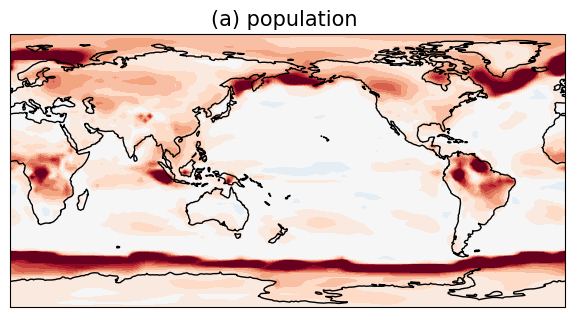

1it [00:04,  4.21s/it]

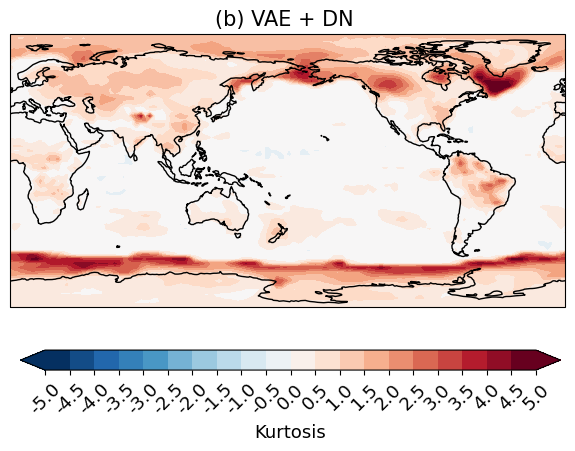

2it [00:08,  4.20s/it]


In [165]:
list_data_toplot = ['population',  'hist_VAE2']
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    sk = kurtosis(dict_anom['population'][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
    ref_ds = xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon)

    # plot_map(ref_ds,
    #                         title=f'{dict_hist_plt[ref]["label"]} ',
    #                         vmin=-5,
    #                         vmax=5,
    #                         cbar=True,
    #                         cbar_label = 'TAS $^{o}C$',
    #                         fig_dir=f'{dir_out}', 
    #                         # fig_name=f'Figure5_{panel}',
    #                         show=True,
    #                         save=False)    
    
    for i, idata in tqdm(enumerate(list_data_toplot)):
                panel = string.ascii_lowercase[i ] 
                sk = kurtosis(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
                ds = xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon)
                if i> 0 :
                    corr = corr_patt(ref_ds, ds).mean().values
                    corr = f' ({str(np.round(corr,2))})'

                    rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
                    rmse = f' {str(np.round(rmse,2))}'
                else:
                    corr = rmse = ''   

                
                cbar = True if i == len(list_data_toplot) - 1 else False
                plot_map((ds),
                            title=f'({panel}) {dict_hist_plt[idata]["label"]} '   ,
                            vmin=-5,
                            vmax=5,

                            cbar=cbar,
                            cbar_label = 'Kurtosis',
                            fig_dir=f'{dir_out}',
                            fig_name=f'Figure3_{panel}',
                              ticks_rotation = 45,
                              fnt_size = 15,
                            nvals=20,
                            figsize = (6,5),

                            show=True,
                            save=False)

0it [00:00, ?it/s]

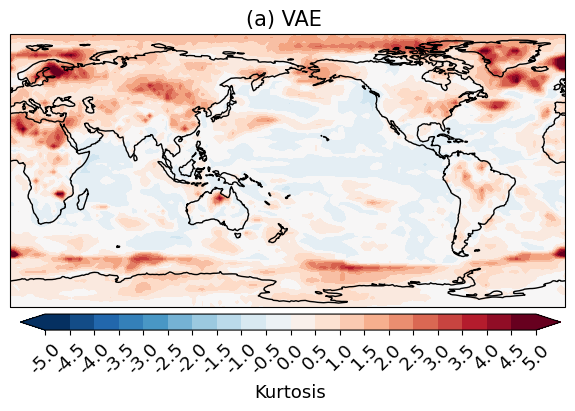

1it [00:09,  9.37s/it]


In [59]:
list_data_toplot = [ 'hist_VAE3']
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    sk = kurtosis(dict_anom['population'][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
    ref_ds = xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon)

    # plot_map(ref_ds,
    #                         title=f'{dict_hist_plt[ref]["label"]} ',
    #                         vmin=-5,
    #                         vmax=5,
    #                         cbar=True,
    #                         cbar_label = 'TAS $^{o}C$',
    #                         fig_dir=f'{dir_out}', 
    #                         # fig_name=f'Figure5_{panel}',
    #                         show=True,
    #                         save=False)    
    
    for i, idata in tqdm(enumerate(list_data_toplot)):
                panel = string.ascii_lowercase[i ] 
                sk = kurtosis(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
                ds = xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon)
                if i> 0 :
                    corr = corr_patt(ref_ds, ds).mean().values
                    corr = f' ({str(np.round(corr,2))})'

                    rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
                    rmse = f' {str(np.round(rmse,2))}'
                else:
                    corr = rmse = ''   

                
                cbar = True if i == len(list_data_toplot) - 1 else False
                plot_map((ds),
                            title=f'({panel}) {dict_hist_plt[idata]["label"]} '   ,
                            figsize =  (6,4),
                            vmin=-5,
                            vmax=5,

                            cbar=cbar,
                            cbar_label = 'Kurtosis',
                            fig_dir=f'{dir_out}',
                            fig_name=f'FigureS2_{panel}',
                            fnt_size = 15,
                              ticks_rotation = 45,
                            nvals=20,
                            show=True,
                            save=False)

In [ ]:
# list_data_toplot = [ 'train_sample', 'hist_VAE1', 'hist_VAE2']
# ref = 'population'

# seaons_to_plot = ['Full']

# for season in seaons_to_plot:
#     sk = kurtosis(dict_anom['population'][var].sel(time = dict_seasons[season]).transpose(...,'realization'), axis = -1)
#     ref_ds = xr.DataArray(sk, dims = ('year','time', 'lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon, year = dict_anom['population'][var].year, time = dict_anom['population'][var].time)

#     plot_map(ref_ds.mean(['year', 'time']),
#                             title=f'{dict_hist_plt[ref]["label"]}, {season} ',
#                             vmin=-5,
#                             vmax=5,
#                             cbar=True,
#                             cbar_label = 'TAS $^{o}C$',
#                             fig_dir=f'{dir_out}', 
#                             # fig_name=f'Figure5_{panel}',
#                             show=True,
#                             save=False)    
    
#     for i, idata in tqdm(enumerate(list_data_toplot)):
                
#                 sk = kurtosis(dict_anom[idata][var].sel(time = dict_seasons[season]).transpose(...,'realization'), axis = -1)
#                 ds = xr.DataArray(sk, dims = ('year','time', 'lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon, year = dict_anom[idata][var].year, time = dict_anom[idata][var].time)

#                 corr = corr_patt(ref_ds, ds).mean().values
#                 corr = f' ({str(np.round(corr,2))})'

#                 rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
#                 rmse = f' {str(np.round(rmse,2))}'

                
#                 cbar = True if i == 0 else False
#                 plot_map((ds).mean(['year', 'time']),
#                             title=f'{dict_hist_plt[idata]["label"]}, {season} ' + rmse + corr ,
#                             vmin=-5,
#                             vmax=5,
#                             cbar=cbar,
#                             cbar_label = 'Skewness',
#                             fig_dir=f'{dir_out}',
#                             # fig_name=f'Figure5_{panel}',
#                             show=True,
#                             save=False)

- mean climate bias

0it [00:00, ?it/s]

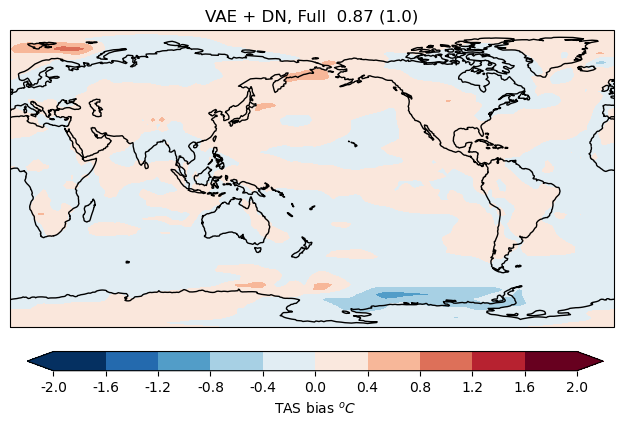

1it [00:43, 43.99s/it]

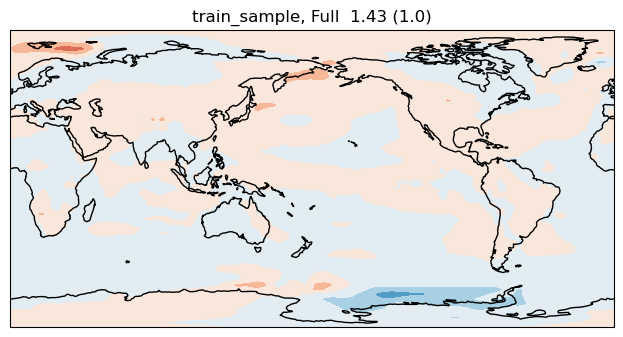

2it [01:27, 43.67s/it]


In [ ]:
# from modules.util_analysis import corr_patt
list_data_toplot = [  'hist_VAE2', 'train_sample' ]
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    ref_ds = dict_data[ref][var].sel(time = dict_seasons[season]).mean(['realization']) - 273.15
    # plot_map(ref_ds.mean('year'),
    #                         title=f'{dict_hist_plt[ref]["label"]}, {season} ',
    #                         vmin=-30,
    #                         vmax=30,
    #                         cbar=True,
    #                         cbar_label = 'TAS $^{o}C$',
    #                         fig_dir=f'{dir_out}', 
    #                         # fig_name=f'Figure5_{panel}',
    #                         show=True,
    #                         save=False)    
    
    for i, idata in tqdm(enumerate(list_data_toplot)):
    
                ds = dict_data[idata][var].sel(time = dict_seasons[season]).mean(['realization']) - 273.15

                corr = corr_patt(ref_ds, ds).mean().values
                corr = f' ({str(np.round(corr,2))})'

                rmse = np.sqrt(((ds - ref_ds)**2).mean(['year', 'time'])).mean().values
                rmse = f' {str(np.round(rmse,2))}'

                
                cbar = True if i == 0 else False
                plot_map((ds - ref_ds).mean(['year', 'time']),
                            title=f'{dict_hist_plt[idata]["label"]}, {season} ' + rmse + corr ,
                            vmin=-2,
                            vmax=2,
                            cbar=cbar,
                            cbar_label = 'TAS bias $^{o}C$',
                            fig_dir=f'{dir_out}',
                            
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)


- Temperature Extremes

In [60]:

from tqdm import tqdm

In [166]:
# seaons_to_plot = ['DJF', 'JJA']
seaons_to_plot = ['Full']

quantiles_toplot = [0.01, 0.99]
dict_extremes = {}

for idata in tqdm(list_data):
    dict_extremes[idata] = {}
    for season in seaons_to_plot:
        dict_extremes[idata][season] = {}
        for qq in [qq for qq in quantiles_toplot if qq != 'None']:
            if idata not in ['obs']:
                dict_extremes[idata][season][qq] = xr.DataArray(np.quantile(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(ens = ('year','realization','time')).squeeze().dropna('ens'), qq, axis = -1),dims=('lat', 'lon'),coords={'lat' : dict_anom[idata].coords['lat'], 'lon' : dict_anom[idata].coords['lon']})
            else:
                dict_extremes[idata][season][qq] = xr.DataArray(np.quantile(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(ens = ('year','time')).squeeze().dropna('ens'), qq, axis = -1),dims=('lat', 'lon'),coords={'lat' : dict_anom[idata].coords['lat'], 'lon' : dict_anom[idata].coords['lon']})

100%|██████████| 4/4 [00:24<00:00,  6.17s/it]


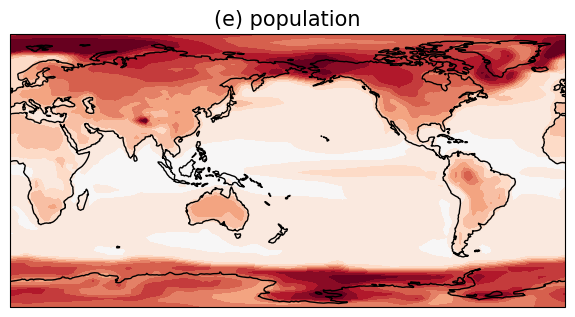

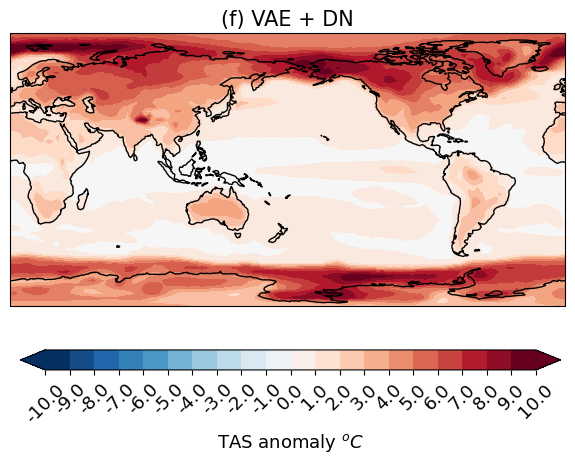

In [167]:
# from modules.util_analysis import corr_patt
list_data_toplot = ['population', 'hist_VAE2']
quantile = 0.99

for season in seaons_to_plot:
    for i, idata in enumerate(list_data_toplot):
            panel = string.ascii_lowercase[i+4] 
        # for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
            try:
                ds = dict_extremes[idata][season][quantile]
                if all(['population' in list_data_toplot, idata != 'population']) : 
                    ref = dict_extremes['population'][season][quantile]
                    corr = str(np.round(corr_patt(ref, ds).values,2))
                    corr = f' ({corr})'
                    rmse = np.sqrt(((ds - ref)**2).mean()).values
                    rmse = f' {str(np.round(rmse,2))}'
                else:
                    corr = ''
                    rmse = ''
                
                cbar = True if i == len(list_data_toplot)-1 else False
                plot_map(ds,
                            title=f'({panel}) {dict_hist_plt[idata]["label"]}',  #{quantile} percentile' + rmse  + corr,
                            vmin=-10,
                            vmax=10,
                            cbar=cbar,
                            figsize = (6,5),
                            cbar_label = 'TAS anomaly $^{o}C$',
                            fig_dir=f'{dir_out}',
                            fig_name=f'Figure3_{panel}',
                            ticks_rotation = 45,
                            nvals=20,
                            fnt_size = 15,
                            show=True,
                            save=False)
            except:
                    print(f'{qq} quantile for {idata} non-existent!')

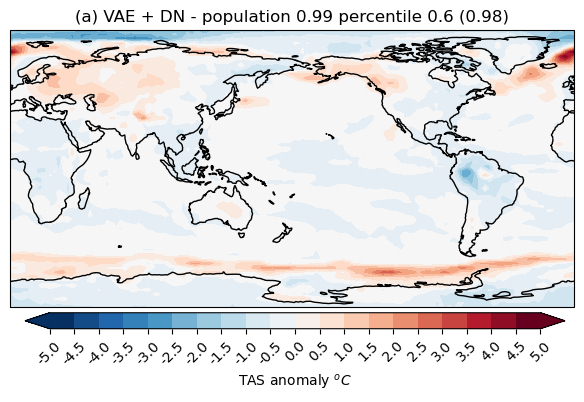

In [63]:
# from modules.util_analysis import corr_patt
list_data_toplot = [ 'hist_VAE2']
quantile = 0.99

for season in seaons_to_plot:
    for i, idata in enumerate(list_data_toplot):
            panel = string.ascii_lowercase[i] 
        # for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
            try:
                ds = dict_extremes[idata][season][quantile]
                ref = dict_extremes['population'][season][quantile]
                corr = str(np.round(corr_patt(ref, ds).values,2))
                corr = f' ({corr})'
                rmse = np.sqrt(((ds - ref)**2).mean()).values
                rmse = f' {str(np.round(rmse,2))}'

                
                cbar = True if i == len(list_data_toplot)-1 else False
                plot_map(ds - ref,
                            title=f'({panel}) {dict_hist_plt[idata]["label"]} - population {quantile} percentile' + rmse  + corr,
                            vmin=-5,
                            vmax=5,
                            cbar=cbar,
                            figsize = (6,4),
                            cbar_label = 'TAS anomaly $^{o}C$',
                            fig_dir=f'{dir_out}',
                            fig_name=f'FigureS3_{panel}',
                            ticks_rotation = 45,
                            nvals=20,
                            show=True,
                            save=False)
            except:
                    print(f'{qq} quantile for {idata} non-existent!')

In [ ]:
# # from modules.util_analysis import corr_patt
# list_data_toplot = ['population', 'hist_VAE2']
# quantile = 0.01

# for season in seaons_to_plot:
#     for i, idata in enumerate(list_data_toplot):
#             panel = string.ascii_lowercase[i + 6] 
#         # for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
#             try:
#                 ds = dict_extremes[idata][season][quantile]
#                 if all(['population' in list_data_toplot, idata != 'population']) : 
#                     ref = dict_extremes['population'][season][quantile]
#                     corr = str(np.round(corr_patt(ref, ds).values,2))
#                     corr = f' ({corr})'
#                     rmse = np.sqrt(((ds - ref)**2).mean()).values
#                     rmse = f' {str(np.round(rmse,2))}'
#                 else:
#                     corr = ''
#                     rmse = ''
                
#                 cbar = True if i == len(list_data_toplot)-1 else False
#                 plot_map(ds,
#                             title=f'({panel}) {dict_hist_plt[idata]["label"]} {quantile} percentile' + rmse  + corr,
#                             vmin=-10,
#                             vmax=10,
#                             cbar=cbar,
#                             cbar_label = 'TAS anomaly $^{o}C$',
#                             fig_dir=f'{dir_out}',
#                             fig_name=f'Figure3_{panel}',
#                             show=True,
#                             save=False)
#             except:
#                     print(f'{qq} quantile for {idata} non-existent!')

- Nino 3.4 Extremes

In [168]:

from tqdm import tqdm

dict_enso_extremes = {}
dict_enso_extremes['nino'] = {}
dict_enso_extremes['nina'] = {}
for idata in tqdm(list_data):
    dict_enso_extremes['nino'][idata] = {}
    dict_enso_extremes['nina'][idata] = {}
    for qq in [qq for qq in quantiles_enso if qq != 'None']:
        (dict_enso_extremes['nino'][idata][qq], 
         dict_enso_extremes['nina'][idata][qq]) = enso_extremes(dict_anom[idata][var].load(),
                                                                dict_enso[idata][var].load(),
                                                                dict_enso['train_sample'][var].load(),
                                                                quantile=float(qq))    

100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


In [169]:
for idata in tqdm([key for key in list_data if key != 'train_sample']):
    (dict_enso_extremes['nino'][idata]['None'], 
     dict_enso_extremes['nina'][idata]['None'])  = enso_extremes(dict_anom[idata][var].load(),
                                                                 dict_enso[idata][var].load(),
                                                                 dict_enso['train_sample'][var].load(),
                                                                 quantile=None)    

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


- Nino 3.4 Extremes (Mean and StdDev)

In [170]:
dict_enso_extremes_mean = {}
dict_enso_extremes_std  = {}
for event in events:
    dict_enso_extremes_mean[event] = {}
    dict_enso_extremes_std[event]  = {}
    for idata in list_data:
        dict_enso_extremes_mean[event][idata] = {}
        dict_enso_extremes_std[event][idata]  = {}
        for qq in quantiles_enso:
            dict_enso_extremes_mean[event][idata][qq] = {}
            dict_enso_extremes_std[event][idata][qq]  = {}

In [171]:

for event in dict_enso_extremes.keys():
    for idata in list_data:
        dimension = ['realization','year']
        if idata in ['obs']:
            dimension = ['year']
        for qq in [qq for qq in quantiles_enso if qq != 'None']:

            dict_enso_extremes_mean[event][idata][qq] = dict_enso_extremes[event][idata][qq].mean(dimension)
            dict_enso_extremes_std[event][idata][qq]  = dict_enso_extremes[event][idata][qq].std(dimension)



In [172]:
qq = 'None'
time_to_show = np.arange(1,13)
for event in dict_enso_extremes.keys():
    for idata in [key for key in list_data if key != 'train_sample']:
        dimension = ['realization','year','time']
        if idata in ['obs']:
            dimension = ['year','time']


        dict_enso_extremes_mean[event][idata][qq]= dict_enso_extremes[event][idata][qq].sel(time=time_to_show).mean(dimension)
        dict_enso_extremes_std[event][idata][qq] = dict_enso_extremes[event][idata][qq].sel(time=time_to_show).std(dimension)


- Figure 5: Mean Extreme Maps

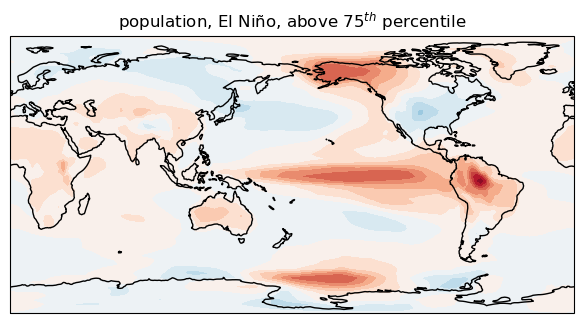

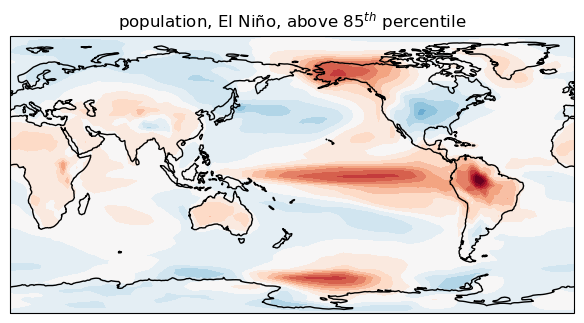

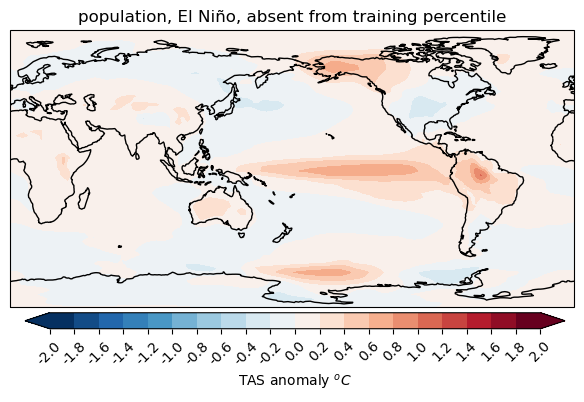

In [173]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'population'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'


        corr = np.round(corr_patt(ds, ref).values, 2)
        
        
        cbar = True if panel == 'c' else False
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin= -2 ,#dict_event_plt[event]['mean_vmin'],
                    vmax= 2, #dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    figsize = (6,4),
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure5_{panel}_detrended',
                    font_size = 15,
                    nvals=20,

                    ticks_rotation=45,
                    show=True,
                    save=False)
    except:
            print(f'{qq} quantile El Niño for {idata} non-existent!')

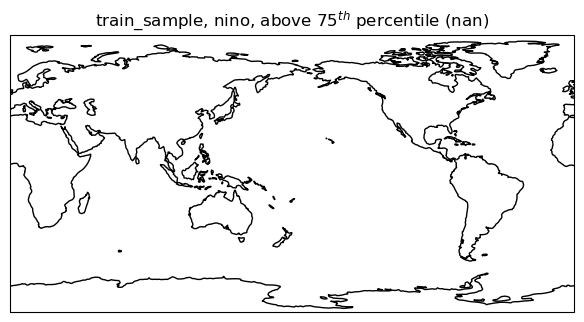

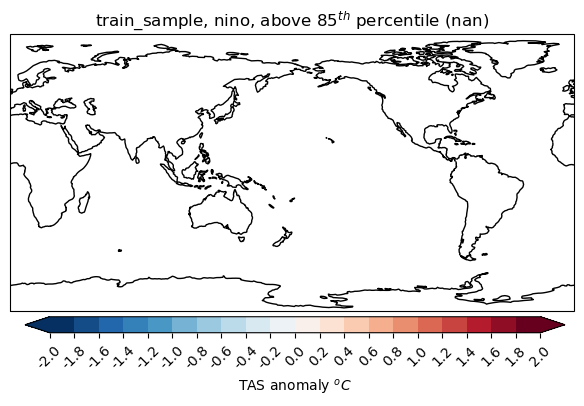

In [174]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'train_sample'

for panel, qq in zip(['a','b'], ['0.75','0.85']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'


        corr = np.round(corr_patt(ds, ref).values, 2)
        
        cbar = True if panel == 'b' else False
            
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, {event}, {quantile} percentile ({str(corr)})',
                    vmin= -2 ,#dict_event_plt[event]['mean_vmin'],
                    vmax= 2, #dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    figsize=(6,4),
                    fig_dir=f'{dir_out}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_name=f'FigureS5_{panel}_detrended',
                    font_size = 15,
                    nvals=20,
                    ticks_rotation=45,
                    show=True,
                    save=False)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

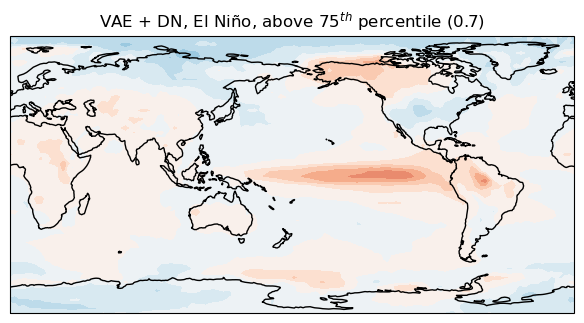

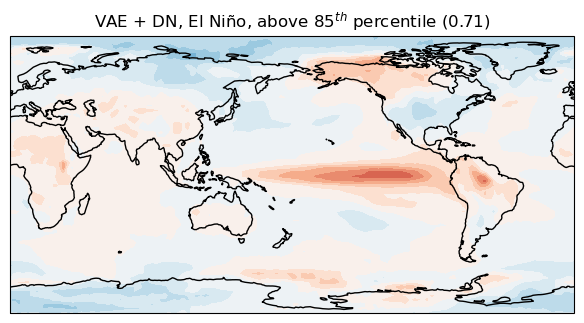

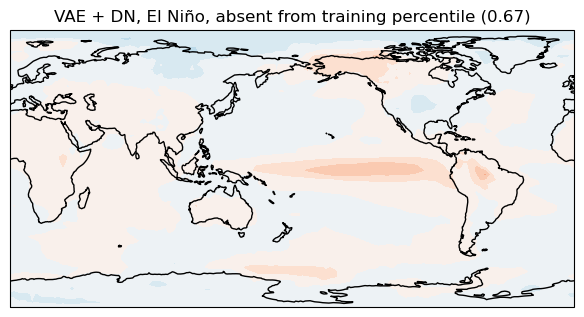

In [175]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_VAE2'

for panel, qq in zip(['f','g','h'], ['0.75','0.85','None']):
    # try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'
        # cbar = True if panel == 'c' else False
        corr = np.round(corr_patt(ds, ref).values, 2)

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin= -2 ,#dict_event_plt[event]['mean_vmin'],
                    vmax= 2, #dict_event_plt[event]['mean_vmax'],
                    cbar=False,
                    figsize=(6,4),
                    fig_dir=f'{dir_out}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_name=f'Figure5_{panel}_detrended',
                    font_size = 15,
                    nvals=20,
                    ticks_rotation=45,
                    show=True,
                    save=False)
    # except:
    #         print(f'{qq} quantile {event} for {idata} non-existent!')

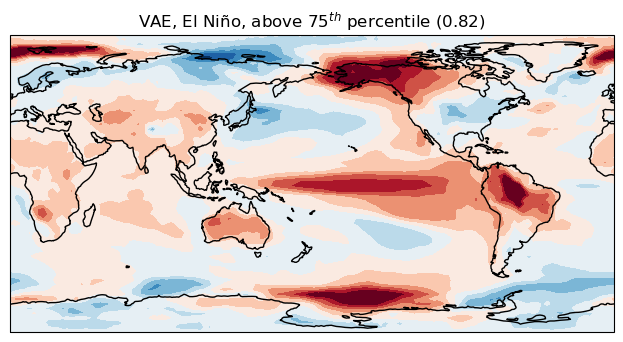

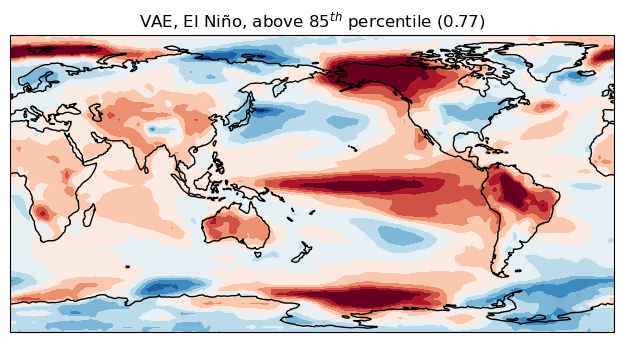

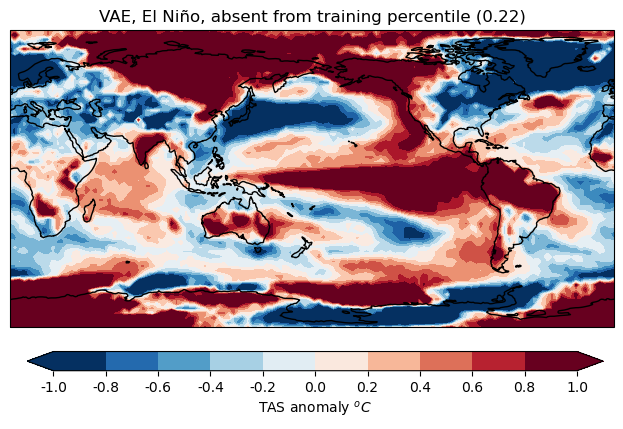

In [72]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_VAE3'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    # try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        corr = np.round(corr_patt(ds, ref).values, 2)

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS7_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=False)
    # except:
    #         print(f'{qq} quantile {event} for {idata} non-existent!')

In [55]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE3'

# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_mean[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['mean_vmin'],
#                     vmax=dict_event_plt[event]['mean_vmax'],
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'Figure5_{panel}',
#                     cbar_label = 'TAS anomaly $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#             print(f'{qq} quantile {event} for {idata} non-existent!')

- Figure 6: Standard Deviation Extreme Maps

In [75]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'population'
for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        
        corr = np.round(corr_patt(ds, ref).values, 2)
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fnt_size=15,
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure6_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for population non-existent!
0.85 quantile nino for population non-existent!
None quantile nino for population non-existent!


In [14]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'train_sample'
for panel, qq in zip(['a','b'], ['0.75','0.85']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        
        corr = np.round(corr_patt(ds, ref).values, 2)            
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, {event}, {qq} precentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=True,
                    fig_dir=f'{dir_out}',
                    fig_name=f'map_std_{dict_hist_plt[idata]["label"]}_{event}_N{qq[2:4]}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for train_sample non-existent!
0.85 quantile nino for train_sample non-existent!


In [15]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_VAE1'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        corr = np.round(corr_patt(ds, ref).values, 2)  

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    fig_name=f'FigureS7_{panel}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for hist_VAE1 non-existent!
0.85 quantile nino for hist_VAE1 non-existent!
None quantile nino for hist_VAE1 non-existent!


In [16]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_benchmark'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        corr = np.round(corr_patt(ds, ref).values, 2)  

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    fig_name=f'FigureS7_{panel}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for hist_benchmark non-existent!
0.85 quantile nino for hist_benchmark non-existent!
None quantile nino for hist_benchmark non-existent!


In [17]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE1'
# for qq in ['None']:
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=True,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS8_g',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

In [18]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE2'
# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS8_{panel}',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

In [104]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE3'
# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'Figure6_{panel}',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

- Power

In [67]:
def power(ds,num_bins = 30,
          anomalies=False):
 
    R_earth_km = 6371
    if anomalies:
        ds_anoms = ds - ds.mean(['lat','lon'])
    else:
        ds_anoms = ds.copy()
 
    # grid = pysh.SHGrid.from_array(ds_anoms)
    # coeffs = grid.expand()
    # spectrum = coeffs.spectrum(lmax=coeffs.lmax)
 
    # l_values = np.arange(1, len(spectrum))  # Degrees l start from 1 (skip l=0)
    # wavelengths_km = 2 * np.pi * R_earth_km / l_values
    fft2 = np.fft.fft2(ds_anoms)
    psd2d = np.abs(fft2)**2         # 2D power spectrum (not normalized)
    psd2d = np.fft.fftshift(psd2d) 
    n_lat, n_lon = ds_anoms.shape
    dlat = 1      # deg per pixel (change if yours is different)
    dlon = 1 
    freq_lat = np.fft.fftshift(np.fft.fftfreq(n_lat, dlat))
    freq_lon = np.fft.fftshift(np.fft.fftfreq(n_lon, dlon))

    f_lon_grid, f_lat_grid = np.meshgrid(freq_lon, freq_lat)
    freq_r = np.sqrt(f_lat_grid**2 + f_lon_grid**2)  
    freq_r_flat = freq_r.ravel()
    psd_flat = psd2d.ravel()

    if num_bins is None:
        num_bins = min(n_lat, n_lon)//2   # or, pick your preferred number of bins
    bins = np.linspace(0, np.max(freq_r), num_bins+1)
    bin_centers = 0.5*(bins[:-1] + bins[1:])

    # Calculate mean power in each radial bin
    radial_mean_power = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (freq_r_flat >= bins[i]) & (freq_r_flat < bins[i+1])
        if np.any(in_bin):
            radial_mean_power[i] = np.mean(psd_flat[in_bin])
        else:
            radial_mean_power[i] = 0.0

    wavelength = 1.0 / bin_centers  # degrees

        # convert degrees → km (great-circle approximation)
    wavelength = np.deg2rad(wavelength) * R_earth_km

    return radial_mean_power, wavelength



# import numpy as np

# def power(
#     field,
#     lat,
#     dlat=2.8,
#     dlon=2.8,
#     nbins=24,
#     to_km=True,
#     cosine_lat = False,
#     R_earth_km=6371.0,
# ):
#     """
#     Radially averaged power spectrum with cosine latitude weighting.

#     Parameters
#     ----------
#     field : 2D array (lat, lon)
#     lat   : 1D array of latitude values (degrees), length = nlat
#     dlat, dlon : grid spacing in degrees
#     nbins : number of radial bins
#     to_km : convert wavelength to km if True
#     R_earth_km : Earth radius for km conversion

#     Returns
#     -------
#     wavelength : 1D array (degrees or km)
#     power      : 1D array (radially averaged spectral power)
#     """

#     ny, nx = field.shape

#     # -------------------------
#     # 1. Remove mean
#     # -------------------------
#     field = field - np.mean(field)

#     # -------------------------
#     # 2. Cosine latitude weighting
#     # -------------------------
#     if cosine_lat:
#         weights = np.cos(np.deg2rad(lat))[:, None]
#         field_w = field * np.sqrt(weights)
#     else:
#         field_w = field
#     # -------------------------
#     # 3. FFT and power spectrum
#     # -------------------------
#     fft2 = np.fft.fft2(field_w)
#     power2d = np.abs(fft2)**2

#     # -------------------------
#     # 4. Wavenumbers (cycles / degree)
#     # -------------------------
#     kx = np.fft.fftfreq(nx, d=dlon)
#     ky = np.fft.fftfreq(ny, d=dlat)
#     kx, ky = np.meshgrid(kx, ky)
#     k = np.sqrt(kx**2 + ky**2)

#     # -------------------------
#     # 5. Flatten & remove zero mode
#     # -------------------------
#     k_flat = k.ravel()
#     p_flat = power2d.ravel()

#     mask = k_flat > 0
#     k_flat = k_flat[mask]
#     p_flat = p_flat[mask]

#     # -------------------------
#     # 6. Log-spaced radial bins
#     # -------------------------
#     k_bins = np.logspace(
#         np.log10(k_flat.min()),
#         np.log10(k_flat.max()),
#         nbins + 1
#     )

#     k_center = np.zeros(nbins)
#     p_radial = np.zeros(nbins)

#     for i in range(nbins):
#         m = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
#         if np.any(m):
#             k_center[i] = k_flat[m].mean()
#             p_radial[i] = p_flat[m].mean()
#         else:
#             k_center[i] = np.nan
#             p_radial[i] = np.nan

#     # -------------------------
#     # 7. Wavenumber → wavelength
#     # -------------------------
#     wavelength = 1.0 / k_center  # degrees

#     if to_km:
#         # convert degrees → km (great-circle approximation)
#         wavelength = np.deg2rad(wavelength) * R_earth_km

#     return p_radial,wavelength


In [68]:
from tqdm import tqdm

In [69]:
# from modules.util_analysis import power

list_data_toplot = ['population', 'train_sample', 'hist_VAE2' ]
years_to_show = np.array(np.arange(1980,2020))  #dict_data[idata].year


dict_power_data = {}

for season in ['DJF', 'JJA']:
    dict_power_data[season] = {}
    for idata in tqdm(list_data_toplot):
        print(idata)
        ds = dict_data[idata][var].load()
        ls_power_t = []
        # for yr in dict_data[idata].year:
        for yr in years_to_show:
            ls_power = []

            for i in tqdm(range(len(dict_data[idata].realization))):
                spectra, wavelengths_km =  power( ds.sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze() ) #, lat = ds.lat.values)  
                ls_power.append( spectra[None, ])

            ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
        # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
        #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
        dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
                                                      coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  


  0%|          | 0/3 [00:00<?, ?it/s]

population


 33%|███▎      | 1/3 [00:34<01:08, 34.16s/it]

train_sample


 67%|██████▋   | 2/3 [00:48<00:22, 22.42s/it]

hist_VAE2


  0%|          | 0/3 [00:00<?, ?it/s]

population


 33%|███▎      | 1/3 [00:07<00:15,  7.71s/it]

train_sample


 67%|██████▋   | 2/3 [00:07<00:03,  3.27s/it]

hist_VAE2


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


In [ ]:
# from modules.util_analysis import power

# list_data_toplot = [ 'hist_VAE4' ]
# years_to_show = np.array([2015])  #dict_data[idata].year


# # dict_power_data = {}

# for season in seasons_to_show:
#     # dict_power_data[season] = {}
#     for idata in (list_data_toplot):
#         print(idata)
#         ls_power_t = []
#         # for yr in dict_data[idata].year:
#         for yr in years_to_show:
#             ls_power = []

#             for i in tqdm(range(len(dict_data[idata].realization))):
#                 spectra, wavelengths_km =  power( dict_data[idata][var].sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze())  
#                 ls_power.append( spectra[None, ])

#             ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
#         # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
#         #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
#         dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
#                                                       coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  


  0%|          | 0/1 [00:00<?, ?it/s]

hist_VAE4


100%|██████████| 1/1 [02:36<00:00, 156.79s/it]


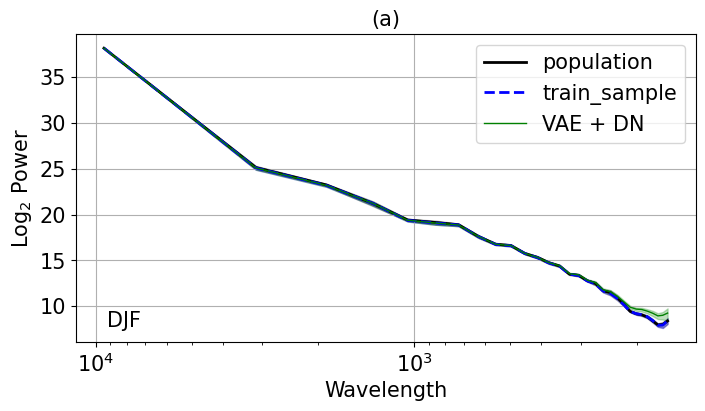

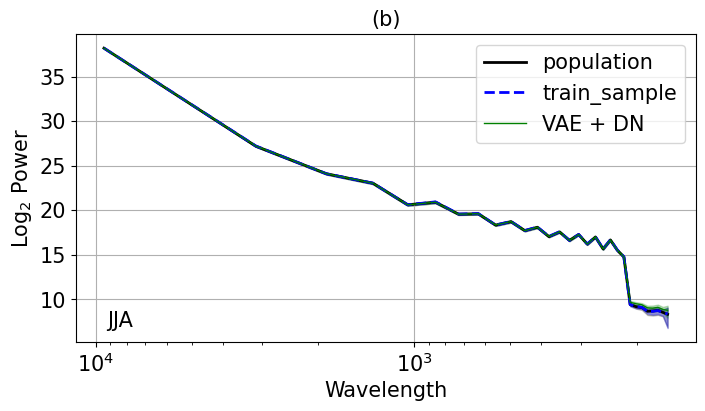

In [73]:
import string

list_data_toplot = ['population', 'train_sample', 'hist_VAE2' ]

dict_plot = dict_hist_plt
save = True
fig_dir=f'{dir_out}'
font_size = 15

for i, season in enumerate(['DJF', 'JJA']):
    panel = string.ascii_lowercase[i ] 
    fig, ax = plt.subplots(1,1,
                           figsize=(8,4))
    for idata in list_data_toplot:

        dstp = dict_power_data[season][idata]
        ax.plot(dstp['wavelength'], np.log2(dstp.mean(['year', 'realization'])), 
                color=dict_plot[idata]['color'],
                label=f'{dict_plot[idata]["label"]}',
                 linestyle = dict_plot[idata]['linestyle'],
                 linewidth = dict_plot[idata]['linewidth'])


        pwr_min = dstp.mean(['year', 'realization']) - dstp.std(['year', 'realization'])
        pwr_max = dstp.mean(['year', 'realization']) + dstp.std(['year', 'realization'])

        ax.fill_between(dstp['wavelength'],
                            np.log2(pwr_min),
                            np.log2(pwr_max),
                            alpha=.25,
                            color=dict_plot[idata]['color'])


    ax.text(0.05,0.05, season , fontsize = 15, transform=ax.transAxes)

    fig_name = f'FigureS6_{panel}'
    plt.xscale('log')

    plt.xlabel('Wavelength', fontsize = font_size)
    plt.ylabel(f'Log$_2$ Power', fontsize = font_size)

    plt.grid(True)
    plt.legend( fontsize = font_size)
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    plt.gca().invert_xaxis()  # Invert the x-axis since larger wavelengths correspond to smaller l-values
    plt.title(f'({panel})', fontsize = 15)


    if save:
        Path(fig_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{fig_dir}/{fig_name}',
                    bbox_inches='tight',
                    dpi=300)



In [74]:
# from modules.util_analysis import power

list_data_toplot = ['population', 'train_sample', 'hist_VAE2', 'hist_VAE3' ]
years_to_show = np.array(np.arange(1980,2020))  #dict_data[idata].year


dict_power_data_anoms = {}

for season in ['DJF', 'JJA']:
# for season in ['Full']:
    dict_power_data_anoms[season] = {}
    for idata in tqdm(list_data_toplot):
        
        print(idata)
        ds = dict_anom[idata][var].load()
        ls_power_t = []
        # for yr in dict_data[idata].year:
        for yr in years_to_show:
            ls_power = []

            for i in range(len(dict_data[idata].realization)):
                spectra, wavelengths_km =  power( ds.sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze() ) #, lat = ds.lat.values)  
                ls_power.append( spectra[None, ])

            ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
        # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
        #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
        dict_power_data_anoms[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
                                                      coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
        






  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:22<01:07, 22.46s/it]

train_sample


 50%|█████     | 2/4 [00:36<00:35, 17.51s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:58<00:19, 19.41s/it]

hist_VAE3


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:07<00:22,  7.46s/it]

train_sample
hist_VAE2


 75%|███████▌  | 3/4 [00:15<00:04,  4.77s/it]

hist_VAE3


100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


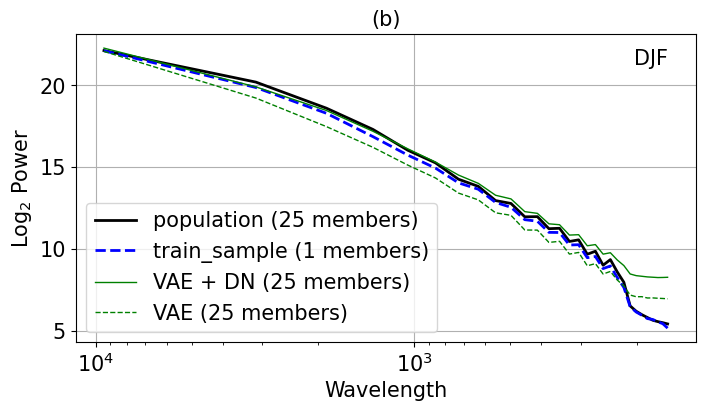

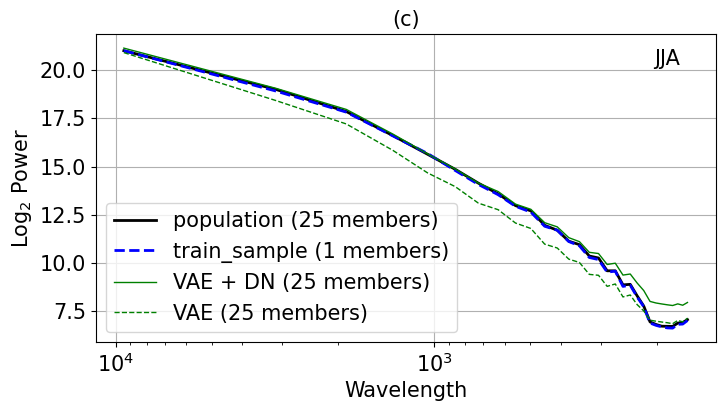

In [77]:
list_data_toplot = ['population', 'train_sample', 'hist_VAE2', 'hist_VAE3' ]

save = True
dict_plot = dict_hist_plt
font_size = 15

fig_dir = dir_out


for i, season in enumerate(['DJF', 'JJA']):
# for i, season in enumerate(['Full']):

    panel = string.ascii_lowercase[i + 1] 
    fig, ax = plt.subplots(1,1,
                           figsize=(8,4))
    for idata in list_data_toplot:

        dstp = dict_power_data_anoms[season][idata]
        ax.plot(dstp['wavelength'], np.log2(dstp.mean(['year', 'realization'])), 
                color=dict_plot[idata]['color'],
                label=f'{dict_plot[idata]["label"]} ({len(dstp.realization)} members)',
                 linestyle = dict_plot[idata]['linestyle'],
                 linewidth = dict_plot[idata]['linewidth'])


        # pwr_min = dstp.mean(['year', 'realization']) - dstp.std(['year', 'realization'])
        # pwr_max = dstp.mean(['year', 'realization']) + dstp.std(['year', 'realization'])

        # ax.fill_between(dstp['wavelength'],
        #                     np.log2(pwr_min),
        #                     np.log2(pwr_max),
        #                     alpha=.25,
        #                     color=dict_plot[idata]['color'])
    ax.text(0.9,0.9, season , fontsize = 15, transform=ax.transAxes)

    fig_name = f'Figure1_{panel}'
    plt.xscale('log')

    plt.xlabel('Wavelength', fontsize = font_size)
    plt.ylabel(f'Log$_2$ Power', fontsize = font_size)

    plt.grid(True)
    plt.legend( fontsize = font_size)
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    plt.gca().invert_xaxis()  # Invert the x-axis since larger wavelengths correspond to smaller l-values
    plt.title(f'({panel})', fontsize = 15)


    if save:
        Path(fig_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{fig_dir}/{fig_name}',
                    bbox_inches='tight',
                    dpi=300)


- La Nina S9-10

In [ ]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nina'
# idata = 'population'

# for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile = f'{np.round(1- eval(qq),2)}'
#             quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_mean[event][idata][qq]
#             quantile = 'absent from training'

#         cbar = True if panel == 'c' else False

#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
#                     vmin=dict_event_plt[event]['mean_vmin'],
#                     vmax=dict_event_plt[event]['mean_vmax'],
#                     cbar=cbar,
#                     cbar_label = 'TAS anomaly $^{o}C$',
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS9_{panel}',
#                     show=True,
#                     save=True)
#     except:
#             print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nina'
# idata = 'clm_cVAE3'

# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile = f'{np.round(1- eval(qq),2)}'
#             quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_mean[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
#                     vmin=dict_event_plt[event]['mean_vmin'],
#                     vmax=dict_event_plt[event]['mean_vmax'],
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS9_{panel}',
#                     cbar_label = 'TAS anomaly $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#             print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nina'
# idata = 'population'
# for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile = f'{np.round(1- eval(qq),2)}'
#             quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'c' else False
            
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=cbar,
                    
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS10_{panel}',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nina'
# idata = 'clm_cVAE3'
# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile = f'{np.round(1- eval(qq),2)}'
#             quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS10_{panel}',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

- Figure 4 Latent space panels

In [11]:
from modules.util_latent import extract_latent_space_clim, prepare_data_for_AE_clim
from modules.util_analysis import doPCA
model_year = 2020
n_components = 500
n_components_cond = 2

model_list = ['hist_VAE2']

In [12]:
model_dict = load_hist_data(['population', 'population_extention'],
                          dict_hist, train_ensemble_size=train_ensemble_size)

model_dict['population'] = model_dict['population'].sel(realization = [f'r{i}i1p2f1' for i in range(1,26)])


for idata in model_dict.keys():
    if idata == 'obs':
        coords_for_clim = ['year']
    else:
        coords_for_clim = ['year','realization']
    model_dict[idata] = model_dict[idata].sel(year = slice('1950', model_year)) - model_dict[idata].sel(year = slice('1950', model_year)).mean(coords_for_clim)



population
====
population_extention
====
population_extention
====


In [13]:
dict_enso_train = {}
for idata in model_dict.keys():
    dict_enso_train[idata] = model_dict[idata].where((model_dict[idata].lat >= -5) & (model_dict[idata].lat<= 5),
                                              drop=True)
    dict_enso_train[idata] = dict_enso_train[idata].where((dict_enso_train[idata].lon >= 190) & (dict_enso_train[idata].lon<= 240),
                                              drop=True).mean(['lat','lon'])    

In [25]:


dict_mu = {}
dict_samples = {}
dict_emb = {}

for idata in model_list:
    model_dir = dict_hist[idata]['dir_in'].split('/tests')[0]
    data_dir = dict_hist['population']['dir_in'] + '/'+ dict_hist['population']['file_in'] + '.nc' 
    data_dir_ssp245 = dict_hist['population_extention']['dir_in'] + '/'+ dict_hist['population_extention']['file_in'] + '.nc' 
    ds_in = xr.open_dataset(data_dir).load()[var]
    if (model_year) >= 2015:
        ds_in_ssp = xr.open_dataset(data_dir_ssp245).sel(year = slice('2015', f'{model_year}')).load()[var]
        ds_in  = xr.concat([ds_in, ds_in_ssp], dim = 'year')
        del ds_in_ssp

    ds_in = ds_in.expand_dims('channels', axis=3).isel(ensembles = np.arange(train_ensemble_size))  


    ds_train, ds_train_conds, params = prepare_data_for_AE_clim(ds_in, model_dir, model_year)
    ds_mu, ds_samples, ds_emb, ds_mu_cond, ds_var_cond, net, params =  extract_latent_space_clim(ds_train, ds_train_conds.expand_dims('channels', axis = 0), params )


    if net.latent_size >2:

        PCAs = {}
        ds_samples,PCAs['samples'], explained_variance_ratio_ = doPCA(ds_samples, n_components=n_components)
        # print(f'ds_samples explained ratio : {explained_variance_ratio_}')
        ds_mu,pca,  explained_variance_ratio_ = doPCA(ds_mu, n_components=n_components) #, fitted_pca = PCAs['samples'])
        # print(f'ds_mu explained ratio : {explained_variance_ratio_}')

        if ds_emb is not None:
            ds_emb, PCAs['emb'], explained_variance_ratio_ = doPCA(ds_emb, n_components=n_components_cond)
            # print(f'ds_emb explained ratio : {explained_variance_ratio_}')

    dict_mu[idata] = ds_mu 
    dict_samples[idata] = ds_samples 
    dict_emb[idata] = ds_emb


: 

In [ ]:
plt.figure(figsize = (6,4))
ax = plt.subplot(1,1,1)

idata = 'hist_VAE2'
fontsize = 12

time_dim = dict_emb[idata].year + (dict_emb[idata].lead_time-0.5)/12

dstp = model_dict['train_sample']['tas'].mean(['lat','lon']).sel(year = slice('1950',f'{model_year}')).mean('realization').squeeze().values.flatten()
dstp = (dstp - dstp.mean())/dstp.std()
plt.plot(time_dim, dstp, color = dict_hist_plt['train_sample']['color'], label = dict_hist_plt['train_sample']['label'] + ' GMT' , linestyle  = dict_hist_plt['train_sample']['linestyle'], alpha = 0.75)


dstp = (dict_emb[idata][:,0] - dict_emb[idata][:,0].mean('time'))/dict_emb[idata][:,0].std('time')
ax.plot(time_dim, dstp, label = 'conditon embedding', color = dict_hist_plt[idata]['color'] )


ax.legend(fontsize = fontsize)
ax.set_ylabel('Dim. 1', fontsize = fontsize)
ax.set_xlabel('time', fontsize = fontsize)
ax.set_title('(a)', fontsize = fontsize)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

# plt.savefig(f'{dir_out}/FigureS0_a',
#             bbox_inches='tight',
#             dpi=300)


In [ ]:
plt.figure(figsize = (6,4))
idata = 'hist_VAE2'
fontsize = 12
ax = plt.subplot(1,1,1)
time_dim = dict_emb[idata].year + (dict_emb[idata].lead_time-0.5)/12

dstp = (dict_emb[idata][:,1] - dict_emb[idata][:,1].mean('time'))/dict_emb[idata][:,1].std('time')
ax.plot(time_dim, dstp, label = 'conditon embedding', color = dict_hist_plt[idata]['color'] )


ax.legend(fontsize = fontsize)
ax.set_ylabel('Dim. 2', fontsize = fontsize)
ax.set_xlabel('time', fontsize = fontsize)
ax.set_title('(b)', fontsize = fontsize)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

# plt.savefig(f'{dir_out}/FigureS0_b',
#             bbox_inches='tight',
#             dpi=300)


In [21]:
from pathlib import Path

In [ ]:
ds_train_enso = dict_enso_train['train_sample'][var][:-1].rename({'time' : 'lead_time' , 'realization' : 'ensembles'}).stack(time = ('year','lead_time')).transpose('time',...)
ds_mu = dict_mu['hist_VAE2']
label = 'VAE'


plt.figure(figsize=(4,4))
colors = [ 'r','g','b','k','c','olive','m','y','purple','tab:red','orange','tab:blue']

month_idx = 0
for t in range(0,len(ds_train_enso.time)):

    plt.subplot(1,1,1)      
    plt.scatter(ds_mu.isel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_mu.isel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k', alpha = 0.25)# colors[ds_train.lead_time[t].values])
    

plt.subplot(1,1,1) 

elnino_samples=  ds_mu.isel(ensembles = params['ensemble_list']).where(ds_train_enso > np.quantile(ds_train_enso,0.9985)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
lanina_samples=  ds_mu.isel(ensembles = params['ensemble_list']).where(ds_train_enso < np.quantile(ds_train_enso,0.0015)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
plt.scatter(elnino_samples.values[:,0], elnino_samples.values[:,1], color = 'r', marker = 'x', s = 200)
plt.scatter(lanina_samples.values[:,0], lanina_samples.values[:,1],  color = 'b', marker = 'x', s = 200)

plt.title(' (a) ' , fontsize = 15)
plt.text(-5,4.2, label, fontsize = 15, alpha = 0.5)

# plt.legend(bbox_to_anchor = (1,1))
# plt.xlabel('PCA2', fontsize = 15)
plt.ylabel('PC1', fontsize = 15)

plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

Path(dir_out).mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{dir_out}/Figure4_a',
#             bbox_inches='tight',
#             dpi=300)

plt.show()

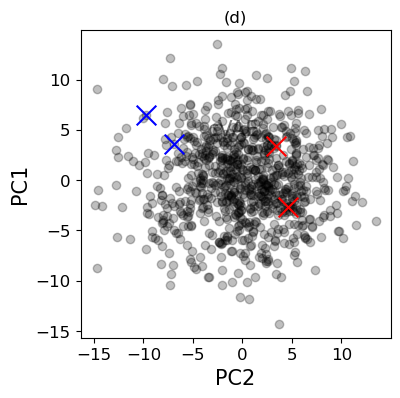

In [49]:
ds_mu = dict_mu['hist_VAE2']
label = 'cVAE'

plt.figure(figsize=(4,4))
colors = [ 'r','g','b','k','c','olive','m','y','purple','tab:red','orange','tab:blue']

month_idx = 0
for t in range(0,len(ds_train_enso.time)):
    # plt.subplot(1,2,1)
    # plt.scatter(ds_samples.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_samples.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k' , alpha = 0.25)#colors[ds_train.lead_time[t].values])

    plt.subplot(1,1,1)      
    plt.scatter(ds_mu.isel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_mu.isel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k', alpha = 0.25)# colors[ds_train.lead_time[t].values])
    



plt.subplot(1,1,1) 

elnino_samples=  ds_mu.isel(ensembles = params['ensemble_list']).where(ds_train_enso > np.quantile(ds_train_enso,0.9985)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
lanina_samples=  ds_mu.isel(ensembles = params['ensemble_list']).where(ds_train_enso < np.quantile(ds_train_enso,0.0015)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
plt.scatter(elnino_samples.values[:,0], elnino_samples.values[:,1], color = 'r', marker = 'x', s = 200)
plt.scatter(lanina_samples.values[:,0], lanina_samples.values[:,1],  color = 'b', marker = 'x', s = 200)

# plt.title('latent space encoding $\mu_{NN}$' + f' - {label}' , fontsize = 15)
plt.text(-3.5,4.5, label, fontsize = 15, alpha = 0.5)
# plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('PC2', fontsize = 15)
plt.ylabel('PC1', fontsize = 15)
plt.title('(d)')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

Path(dir_out).mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{dir_out}/Figure4_d',
#             bbox_inches='tight',
#             dpi=300)

plt.show()